In [1]:
import pandas as pd
import os
from skimage.io import imread
import numpy as np
from sklearn.metrics import  mean_absolute_error, mean_squared_error, root_mean_squared_error
import tifffile as tiff
import cv2

from utils.eval_plots_utils import *

pd.set_option('display.max_rows', None)

Part 1: Mean/Std Cell Area and Fluorescent Intensity

In [2]:
base_path = '/vol/biomedic3/bglocker/mscproj24/nma23/data/testing_directory/multi_model/'

    # Lists of experiments and models
    no_gt_exps = ['exp1', 'exp2', 'exp3', 'exp4', 'exp5']
    no_gt_models = [
        'PHANTAST', 'vit_b', 'vit_b_lm_amg', 'vit_b_lm_ais',
        'vit_l', 'vit_l_lm_amg', 'vit_l_lm_ais', 'cellpose3',
        'ensemble_1', 'ensemble_2', 'ensemble_3', 
        'ensemble_4_w_PHANTAST', 'ensemble_5_w_PHANTAST'
    ]

    with_gt_exps = ['gt_exp1', 'gt_exp2', 'gt_exp3', 'gt_exp4', 'gt_exp5']
    with_gt_models = [
        'PHANTAST', 'vit_b', 'vit_b_lm_amg', 'vit_b_lm_ais',
        'vit_l', 'vit_l_lm_amg', 'vit_l_lm_ais', 'cellpose3',
        'ensemble_1', 'ensemble_2', 'ensemble_3', 
        'ensemble_4_w_PHANTAST', 'ensemble_5_w_PHANTAST', 'Ground_truth'
    ]


    # Construct nested dictionaries
    phantast_results_csv_file_paths = {
        exp: {
            model: os.path.join(base_path, f'{exp}/Model_{model}/Results/Results.csv')
            for model in no_gt_models
        }
        for exp in no_gt_exps
    }

    gt_results_csv_file_paths = {
        exp: {
            model: os.path.join(base_path, f'{exp}/{model}/Results/Results.csv')
            if model == 'Ground_truth'
            else os.path.join(base_path, f'{exp}/Model_{model}/Results/Results.csv')
            for model in with_gt_models
        }
        for exp in with_gt_exps
    }

    phantast_masks_file_paths = {
        exp: {
            model: os.path.join(base_path, f'{exp}/Model_{model}/Segmentation_Output/Mask_Stack.tiff')
            for model in no_gt_models
        }
        for exp in no_gt_exps
    }

    gt_masks_file_paths = {
        exp: {
            model: os.path.join(base_path, f'{exp}/{model}/Segmentation_Output/GT_Mask_Stack.tiff')
            if model == 'Ground_truth'
            else os.path.join(base_path, f'{exp}/Model_{model}/Segmentation_Output/Mask_Stack.tiff')
            for model in with_gt_models
        }
        for exp in with_gt_exps
    }

    print(phantast_results_csv_file_paths)
    print(gt_results_csv_file_paths)
    print(phantast_masks_file_paths)
    print(gt_masks_file_paths)


{'exp1': {'PHANTAST': '/vol/biomedic3/bglocker/mscproj24/nma23/data/testing_directory/multi_model/exp1/Model_PHANTAST/Results/Results.csv', 'vit_b': '/vol/biomedic3/bglocker/mscproj24/nma23/data/testing_directory/multi_model/exp1/Model_vit_b/Results/Results.csv', 'vit_b_lm_amg': '/vol/biomedic3/bglocker/mscproj24/nma23/data/testing_directory/multi_model/exp1/Model_vit_b_lm_amg/Results/Results.csv', 'vit_b_lm_ais': '/vol/biomedic3/bglocker/mscproj24/nma23/data/testing_directory/multi_model/exp1/Model_vit_b_lm_ais/Results/Results.csv', 'vit_l': '/vol/biomedic3/bglocker/mscproj24/nma23/data/testing_directory/multi_model/exp1/Model_vit_l/Results/Results.csv', 'vit_l_lm_amg': '/vol/biomedic3/bglocker/mscproj24/nma23/data/testing_directory/multi_model/exp1/Model_vit_l_lm_amg/Results/Results.csv', 'vit_l_lm_ais': '/vol/biomedic3/bglocker/mscproj24/nma23/data/testing_directory/multi_model/exp1/Model_vit_l_lm_ais/Results/Results.csv', 'cellpose3': '/vol/biomedic3/bglocker/mscproj24/nma23/data/t

In [3]:
# Load data for models

models = ['PHANTAST', 'vit_b', 'vit_b_lm_amg', 'vit_b_lm_ais', 'vit_l', 'vit_l_lm_amg', 'vit_l_lm_ais', 'cellpose3', 'ensemble_1', 'ensemble_2', 'ensemble_3', 'ensemble_4_w_PHANTAST', 'ensemble_5_w_PHANTAST']

# All ML models, ie all models except PHANTAST
ml_models = models[1:]

############ phantast_file_paths_by_exp ############

# Load no GT experiments data
nogt_data = {} # Dictionary (key = model name; value = corresponding data from load_nogt_data)
for model in models:
    nogt_data[model] = load_nogt_data(model, phantast_results_csv_file_paths) 

print("Keys in nogt_data:", nogt_data.keys())

# Just PHANTAST data
phantast_data = nogt_data['PHANTAST']

data_against_phantast = {model: pd.concat([phantast_data, nogt_data[model]], ignore_index=True) for model in ml_models}

############ gt_file_paths_by_exp ############

# Load ground truth experiments data
# gt_data = {} initialised in fxn
gt_data = load_gt_data(gt_results_csv_file_paths)
print("Keys in gt_data:", gt_data.keys())


# DataFrame for analysis of models against ground truth
# data_against_gt = {model: pd.concat([gt_data, gt_data[model]], ignore_index=True) for model in models}
data_against_gt = {}  # Initialize an empty dictionary to store results

ground_truth_df = gt_data['Ground_truth']  # Extract the Ground_truth DataFrame

for model in models:
    if model in gt_data:
        # Concatenate the Ground_truth DataFrame with the current model's DataFrame
        concatenated_df = pd.concat([ground_truth_df, gt_data[model]], ignore_index=True)
        data_against_gt[model] = concatenated_df  # Store the result in the dictionary
    else:
        print(f"Warning: Data for model {model} not found in gt_data.")


############ All models ############

# DataFrame for analysis of all models together
all_model_data = pd.concat([nogt_data[model] for model in models], ignore_index=True)

# Concatenate all model data with ground truth data
all_gt_data = pd.concat([gt_data[model] for model in models if model in gt_data], ignore_index=True)

# Combine all data together
all_data = pd.concat([all_model_data, all_gt_data], ignore_index=True)



Loading data for model PHANTAST from file: /vol/biomedic3/bglocker/mscproj24/nma23/data/testing_directory/multi_model/exp1/Model_PHANTAST/Results/Results.csv
Loading data for model PHANTAST from file: /vol/biomedic3/bglocker/mscproj24/nma23/data/testing_directory/multi_model/exp2/Model_PHANTAST/Results/Results.csv
Loading data for model PHANTAST from file: /vol/biomedic3/bglocker/mscproj24/nma23/data/testing_directory/multi_model/exp3/Model_PHANTAST/Results/Results.csv
Loading data for model PHANTAST from file: /vol/biomedic3/bglocker/mscproj24/nma23/data/testing_directory/multi_model/exp4/Model_PHANTAST/Results/Results.csv
Loading data for model PHANTAST from file: /vol/biomedic3/bglocker/mscproj24/nma23/data/testing_directory/multi_model/exp5/Model_PHANTAST/Results/Results.csv
Loading data for model vit_b from file: /vol/biomedic3/bglocker/mscproj24/nma23/data/testing_directory/multi_model/exp1/Model_vit_b/Results/Results.csv
Loading data for model vit_b from file: /vol/biomedic3/bgl

In [5]:
# All Mean / Std Data per Experiment

phantast_results_df = process_data(phantast_results_csv_file_paths) 
print("All Data from No GT Experiments - Averages and Standard Deviations per Model per Experiment")
display(phantast_results_df)


gt_results_df = process_data(gt_results_csv_file_paths) 
print("All Data from GT Experiments - Averages and Standard Deviations per Model per Experiment")
display(gt_results_df)

All Data from No GT Experiments - Averages and Standard Deviations per Model per Experiment


,Experiment,Model,Mean Cell Area,Mean Intensity,Std Cell Area,Std Intensity
0,exp1,PHANTAST,629285.16,56.6543,208573.436951,46.686230
1,exp1,vit_b,495539.68,59.4896,107787.112311,49.779097
2,exp1,vit_b_lm_amg,131164.42,51.7334,52372.152576,44.069173
3,exp1,vit_b_lm_ais,513625.18,65.0081,166465.344318,55.170893
4,exp1,vit_l,552602.80,58.8989,128130.996660,48.624425
5,exp1,vit_l_lm_amg,213789.98,56.8944,68419.681799,48.468640
6,exp1,vit_l_lm_ais,585574.72,63.3895,173543.398755,53.941613
7,exp1,cellpose3,446606.16,61.3918,145179.404219,51.338532
8,exp1,ensemble_1,546490.56,65.2495,157182.066529,55.954127
9,exp1,ensemble_2,525844.82,62.0004,123682.356768,52.358997


All Data from GT Experiments - Averages and Standard Deviations per Model per Experiment


,Experiment,Model,Mean Cell Area,Mean Intensity,Std Cell Area,Std Intensity
0,gt_exp1,PHANTAST,489848.580000,NaN,231267.263375,NaN
1,gt_exp1,vit_b,408111.400000,NaN,151245.239376,NaN
2,gt_exp1,vit_b_lm_amg,45157.286667,NaN,31116.507479,NaN
3,gt_exp1,vit_b_lm_ais,253747.540000,NaN,174543.361229,NaN
4,gt_exp1,vit_l,492532.480000,NaN,145698.147764,NaN
5,gt_exp1,vit_l_lm_amg,94918.973333,NaN,51745.774943,NaN
6,gt_exp1,vit_l_lm_ais,364568.326667,NaN,219994.568113,NaN
7,gt_exp1,cellpose3,198977.153333,NaN,164698.549547,NaN
8,gt_exp1,ensemble_1,323937.720000,NaN,194962.686772,NaN
9,gt_exp1,ensemble_2,418581.446667,NaN,168610.189905,NaN


In [6]:
# Display aggregate data across models, per experiment; describes differences in the dataset not due to the model choice

numeric_columns = phantast_results_df.select_dtypes(include='number').columns # Ensure only numeric columns are included in the groupby operation
exp_measurements_df = phantast_results_df.groupby('Experiment')[numeric_columns].mean().reset_index()
print("All Data from No GT Experiments - Measurements Per Experiment")
display(exp_measurements_df)

numeric_columns = gt_results_df.select_dtypes(include='number').columns
exp_measurements_df = gt_results_df.groupby('Experiment')[numeric_columns].mean().reset_index()
print("All Data from GT Experiments - Measurements Per Experiment")
display(exp_measurements_df)

All Data from No GT Experiments - Measurements Per Experiment


,Experiment,Mean Cell Area,Mean Intensity,Std Cell Area,Std Intensity
0,exp1,469935.383077,61.033300,134222.205430,51.566617
1,exp2,424061.516923,58.531338,150667.842657,54.333837
2,exp3,487242.970769,54.242938,125384.499894,58.848651
3,exp4,471969.652308,60.913723,119390.932328,50.887700
4,exp5,451032.923077,69.925969,150137.235787,52.796698


All Data from GT Experiments - Measurements Per Experiment


,Experiment,Mean Cell Area,Mean Intensity,Std Cell Area,Std Intensity
0,gt_exp1,330888.083810,NaN,164340.717237,NaN
1,gt_exp2,321114.270952,NaN,144118.800967,NaN
2,gt_exp3,240786.720000,NaN,123827.134251,NaN
3,gt_exp4,152399.957143,NaN,95274.877365,NaN
4,gt_exp5,88252.641429,NaN,86679.299043,NaN


In [7]:
# Display aggregate data across experiments, per model

numeric_columns = phantast_results_df.select_dtypes(include='number').columns
model_measurements_df = phantast_results_df.groupby('Model')[numeric_columns].mean().reset_index()
print(f"No GT Experiments - Measurements Per Model Across All Experiments")
display(model_measurements_df)

numeric_columns = gt_results_df.select_dtypes(include='number').columns
model_measurements_df = gt_results_df.groupby('Model')[numeric_columns].mean().reset_index()
print(f"GT Experiments - Measurements Per Model Across All Experiments")
display(model_measurements_df)

No GT Experiments - Measurements Per Model Across All Experiments


,Model,Mean Cell Area,Mean Intensity,Std Cell Area,Std Intensity
0,PHANTAST,610767.272,57.29058,209794.270141,48.842217
1,cellpose3,438972.176,62.20518,144533.479046,54.724137
2,ensemble_1,536209.872,65.07882,156618.249201,58.022185
3,ensemble_2,521025.760,60.75236,127743.282180,52.030981
4,ensemble_3,501521.168,64.91118,148986.900326,57.973201
5,ensemble_4_w_PHANTAST,404892.704,63.56360,114556.675810,55.076437
6,ensemble_5_w_PHANTAST,531511.756,63.50834,163528.893547,55.435538
7,vit_b,491192.704,58.85896,115551.273481,50.240800
8,vit_b_lm_ais,502155.952,64.97224,163529.778248,57.405565
9,vit_b_lm_amg,126116.664,54.85442,55595.576242,52.480177


GT Experiments - Measurements Per Model Across All Experiments


,Model,Mean Cell Area,Mean Intensity,Std Cell Area,Std Intensity
0,Ground_truth,381066.038667,NaN,152763.073373,NaN
1,PHANTAST,323704.226667,NaN,166137.217463,NaN
2,cellpose3,122487.316000,NaN,111039.306552,NaN
3,ensemble_1,202741.718667,NaN,131092.964212,NaN
4,ensemble_2,313256.648000,NaN,138433.663909,NaN
5,ensemble_3,185800.248000,NaN,127219.494719,NaN
6,ensemble_4_w_PHANTAST,191383.064000,NaN,106747.173529,NaN
7,ensemble_5_w_PHANTAST,228862.474667,NaN,130053.112207,NaN
8,vit_b,319215.205333,NaN,132530.335896,NaN
9,vit_b_lm_ais,145335.976000,NaN,104858.153075,NaN


In [8]:

# Plot for ground truth comparison
def plot_violin_plots_gt(y_data, y_axis_label, using_gt=True, split=False):
    if using_gt:
        models_to_plot = models  # Compare against ground truth
    else:
        models_to_plot = models[1:]  # Compare against PHANTAST (skip PHANTAST itself)
    
    num_models = len(models_to_plot)
    num_cols = 3 
    num_rows = (num_models + num_cols - 1) // num_cols 

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5 * num_cols, 6 * num_rows), sharey=True)
    axes = axes.flatten()

    for idx, model in enumerate(models_to_plot):
        # Check if data exists for model
        print(f"\nPlotting for model: {model}")
        print(f"Data for model ({model}) head:\n{gt_data[model].head()}")
        
        # Concatenate ground truth data with model data for the current model
        concat_data = pd.concat([gt_data['Ground_truth'], gt_data[model]], ignore_index=True)
    
        # Plot
        if not split:
            sns.violinplot(ax=axes[idx], x='Model', y=y_data, data=concat_data, hue='Model', 
                           palette={'Ground_truth': 'blue', model: 'orange'}, legend=False)
        else:
            sns.violinplot(ax=axes[idx], x='Model', y=y_data, data=data_against_gt, hue='Model', 
                           split=True, palette={'Ground_truth': 'blue', model: 'orange'}, inner="quart")

        axes[idx].set_title(f'{y_axis_label}: Ground Truth vs {model}')
        axes[idx].set_xlabel('Model')
        if idx % num_cols == 0:  # Only label the y-axis on the leftmost plots
            axes[idx].set_ylabel(y_axis_label)
        else:
            axes[idx].set_ylabel('')
    
    # Hide unused subplots
    for j in range(len(models_to_plot), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Plot for PHANTAST comparison
def plot_violin_plots_phantast(y_data, y_axis_label, using_gt=False, split=False):
    if using_gt:
        models_to_plot = models  # Compare against ground truth
    else:
        models_to_plot = models[1:]  # Compare against PHANTAST (skip PHANTAST itself)
    
    num_models = len(models_to_plot)
    num_cols = 3 
    num_rows = (num_models + num_cols - 1) // num_cols 

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5 * num_cols, 6 * num_rows), sharey=True)
    axes = axes.flatten()

    for idx, model in enumerate(models_to_plot):
        # Check if data exists for model
        print(f"\nPlotting for model: {model}")
        print(f"Data for model ({model}) head:\n{nogt_data[model].head()}")
        
        # Concatenate ground truth data with model data for the current model
        concat_data = pd.concat([phantast_data, nogt_data[model]], ignore_index=True)
    
        # Plot
        if not split:
            sns.violinplot(ax=axes[idx], x='Model', y=y_data, data=concat_data, hue='Model', 
                           palette={'PHANTAST': 'blue', model: 'orange'}, legend=False)
        else:
            sns.violinplot(ax=axes[idx], x='Model', y=y_data, data=concat_data, hue='Model', 
                           split=True, palette={'PHANTAST': 'blue', model: 'orange'}, inner="quart")

        axes[idx].set_title(f'{y_axis_label}: PHANTAST vs {model}')
        axes[idx].set_xlabel('Model')
        if idx % num_cols == 0:  # Only label the y-axis on the leftmost plots
            axes[idx].set_ylabel(y_axis_label)
        else:
            axes[idx].set_ylabel('')
    
    # Hide unused subplots
    for j in range(len(models_to_plot), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


Plotting for model: PHANTAST
Data for model (PHANTAST) head:
                           Label    Area  Mean  Slice  MinThr  MaxThr  \
0  Result of ground truth tiff:1  480956   NaN      1       1   65535   
1  Result of ground truth tiff:2  770701   NaN      2       1   65535   
2  Result of ground truth tiff:3  855305   NaN      3       1   65535   
3  Result of ground truth tiff:4  647943   NaN      4       1   65535   
4  Result of ground truth tiff:5  384132   NaN      5       1   65535   

      Model  
0  PHANTAST  
1  PHANTAST  
2  PHANTAST  
3  PHANTAST  
4  PHANTAST  

Plotting for model: vit_b
Data for model (vit_b) head:
                           Label    Area  Mean  Slice  MinThr  MaxThr  Model
0  Result of ground truth tiff:1  491194   NaN      1       1   65535  vit_b
1  Result of ground truth tiff:2  608231   NaN      2       1   65535  vit_b
2  Result of ground truth tiff:3  634299   NaN      3       1   65535  vit_b
3  Result of ground truth tiff:4  521089   NaN     

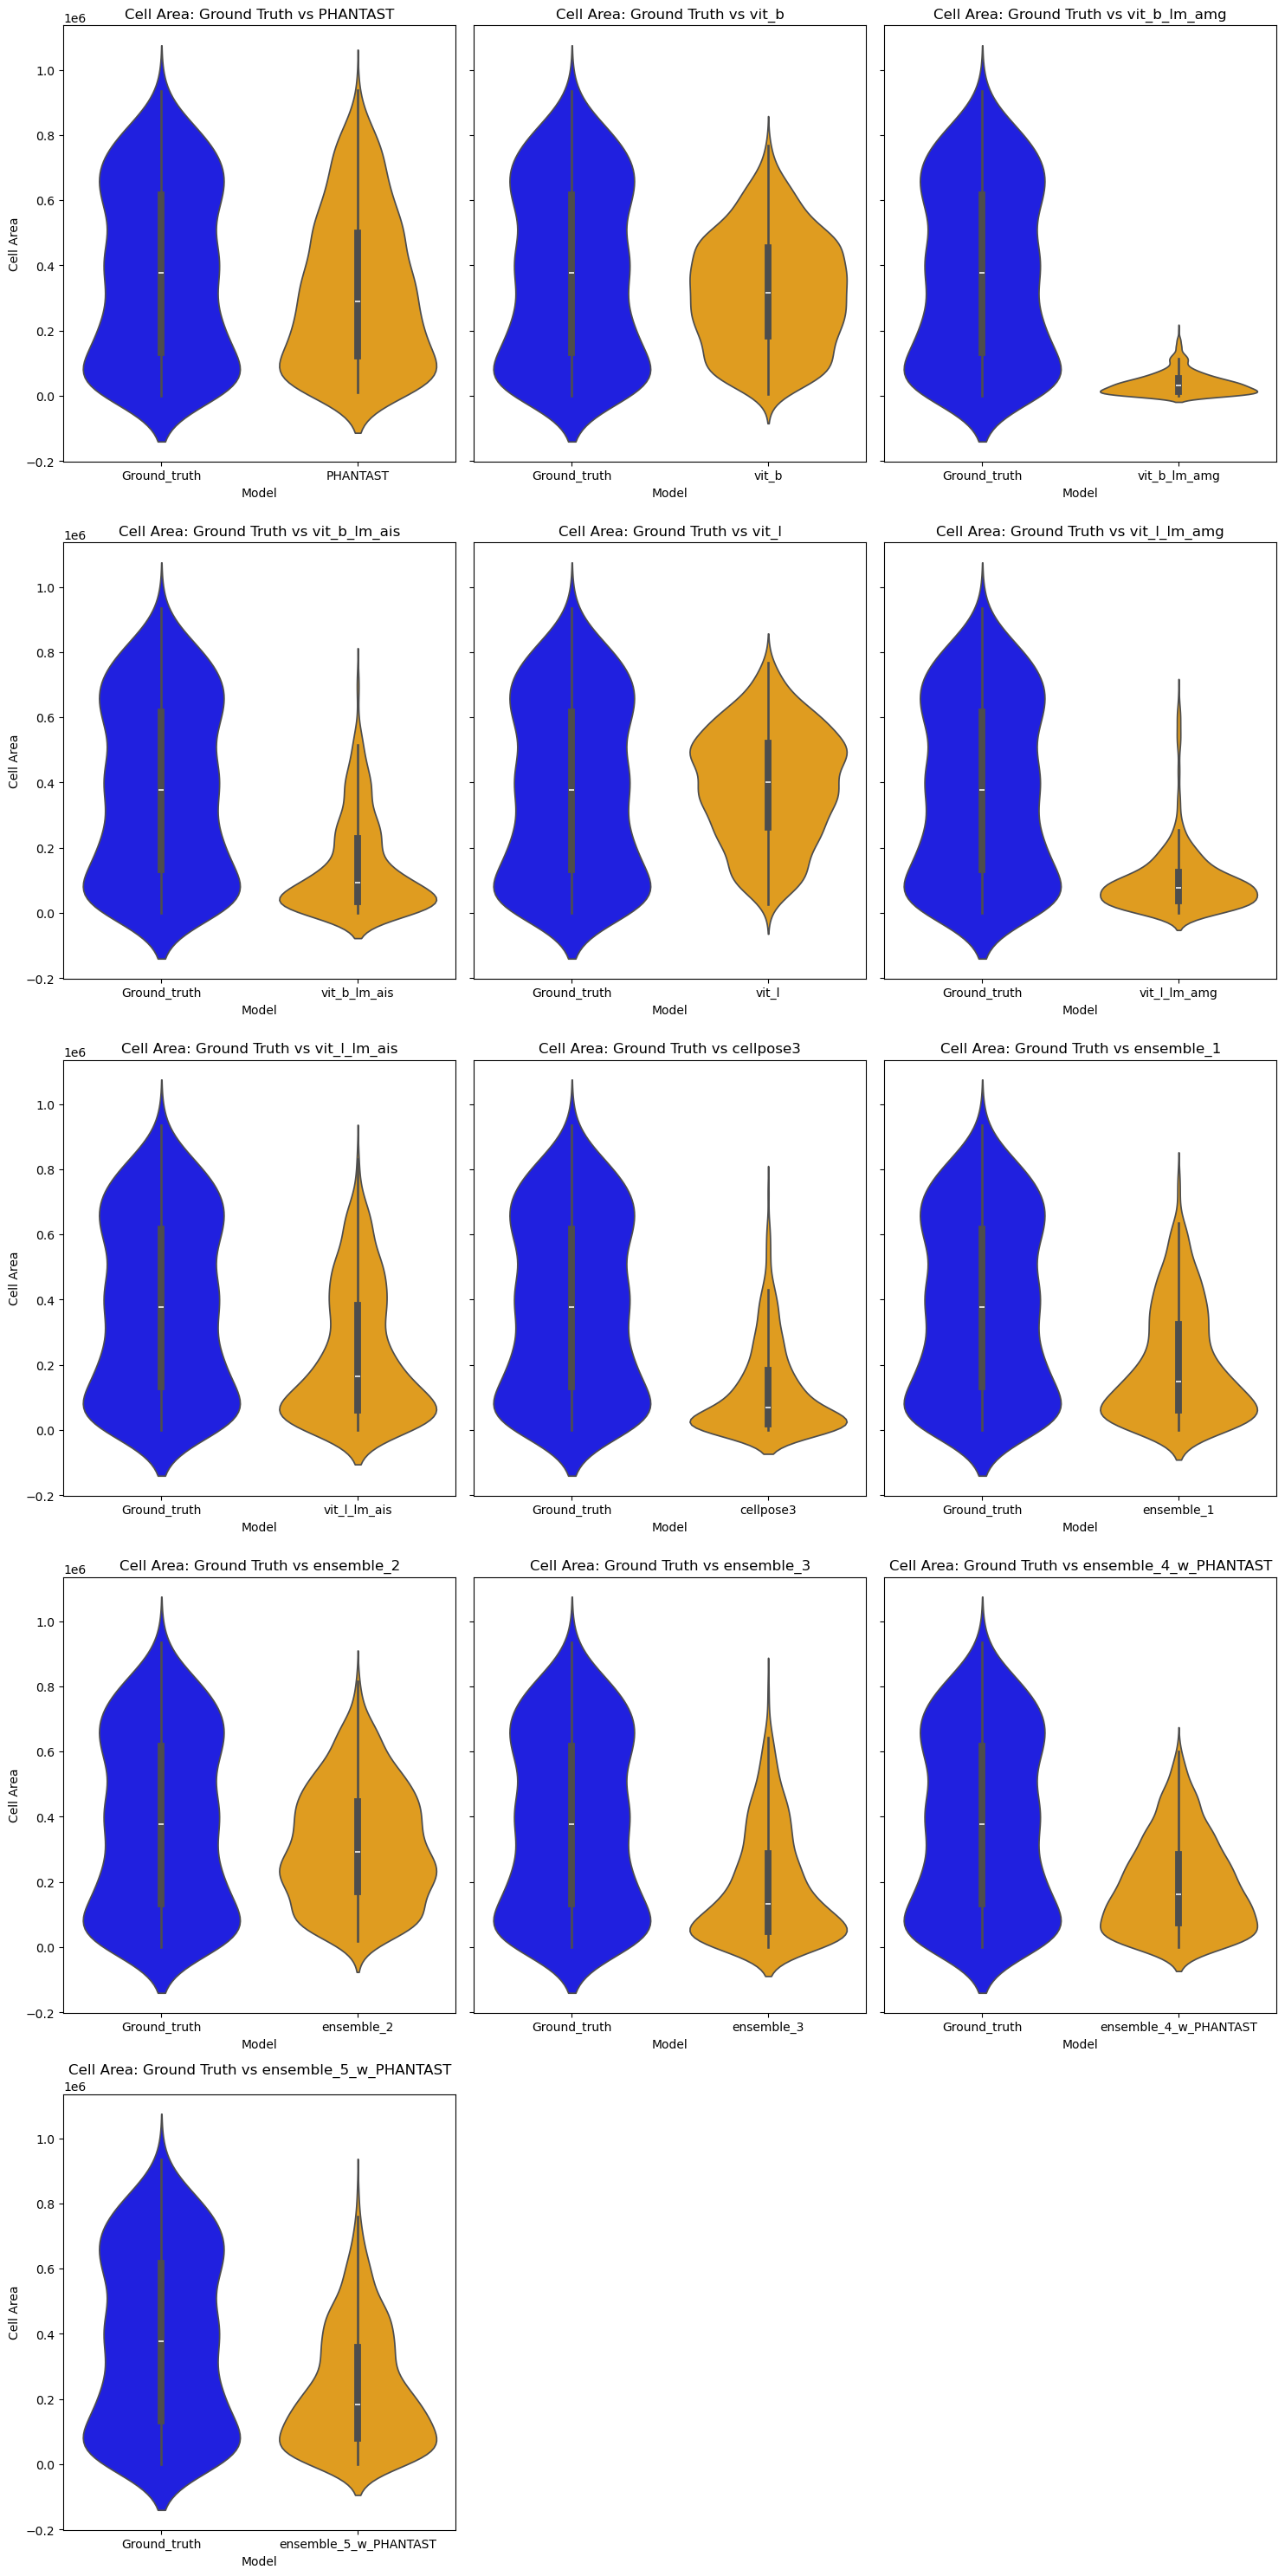

In [9]:
# Violin plots: Ground truth vs models (including PHANTAST) for cell area

plot_violin_plots_gt('Area', 'Cell Area', using_gt=True, split=False)


Plotting for model: vit_b
Data for model (vit_b) head:
                                  Label    Area    Mean  Slice  MinThr  \
0  Result of Corrected_Flo_Image.tiff:1  254511  169.47      1       1   
1  Result of Corrected_Flo_Image.tiff:2  254511  124.58      2       1   
2  Result of Corrected_Flo_Image.tiff:3  482855  134.78      3       1   
3  Result of Corrected_Flo_Image.tiff:4  482855   57.82      4       1   
4  Result of Corrected_Flo_Image.tiff:5  555253  220.38      5       1   

   MaxThr Experiment  Model  
0   65535       exp1  vit_b  
1   65535       exp1  vit_b  
2   65535       exp1  vit_b  
3   65535       exp1  vit_b  
4   65535       exp1  vit_b  

Plotting for model: vit_b_lm_amg
Data for model (vit_b_lm_amg) head:
                                  Label   Area   Mean  Slice  MinThr  MaxThr  \
0  Result of Corrected_Flo_Image.tiff:1  94993  82.70      1       1   65535   
1  Result of Corrected_Flo_Image.tiff:2  94993  58.85      2       1   65535   
2  Result

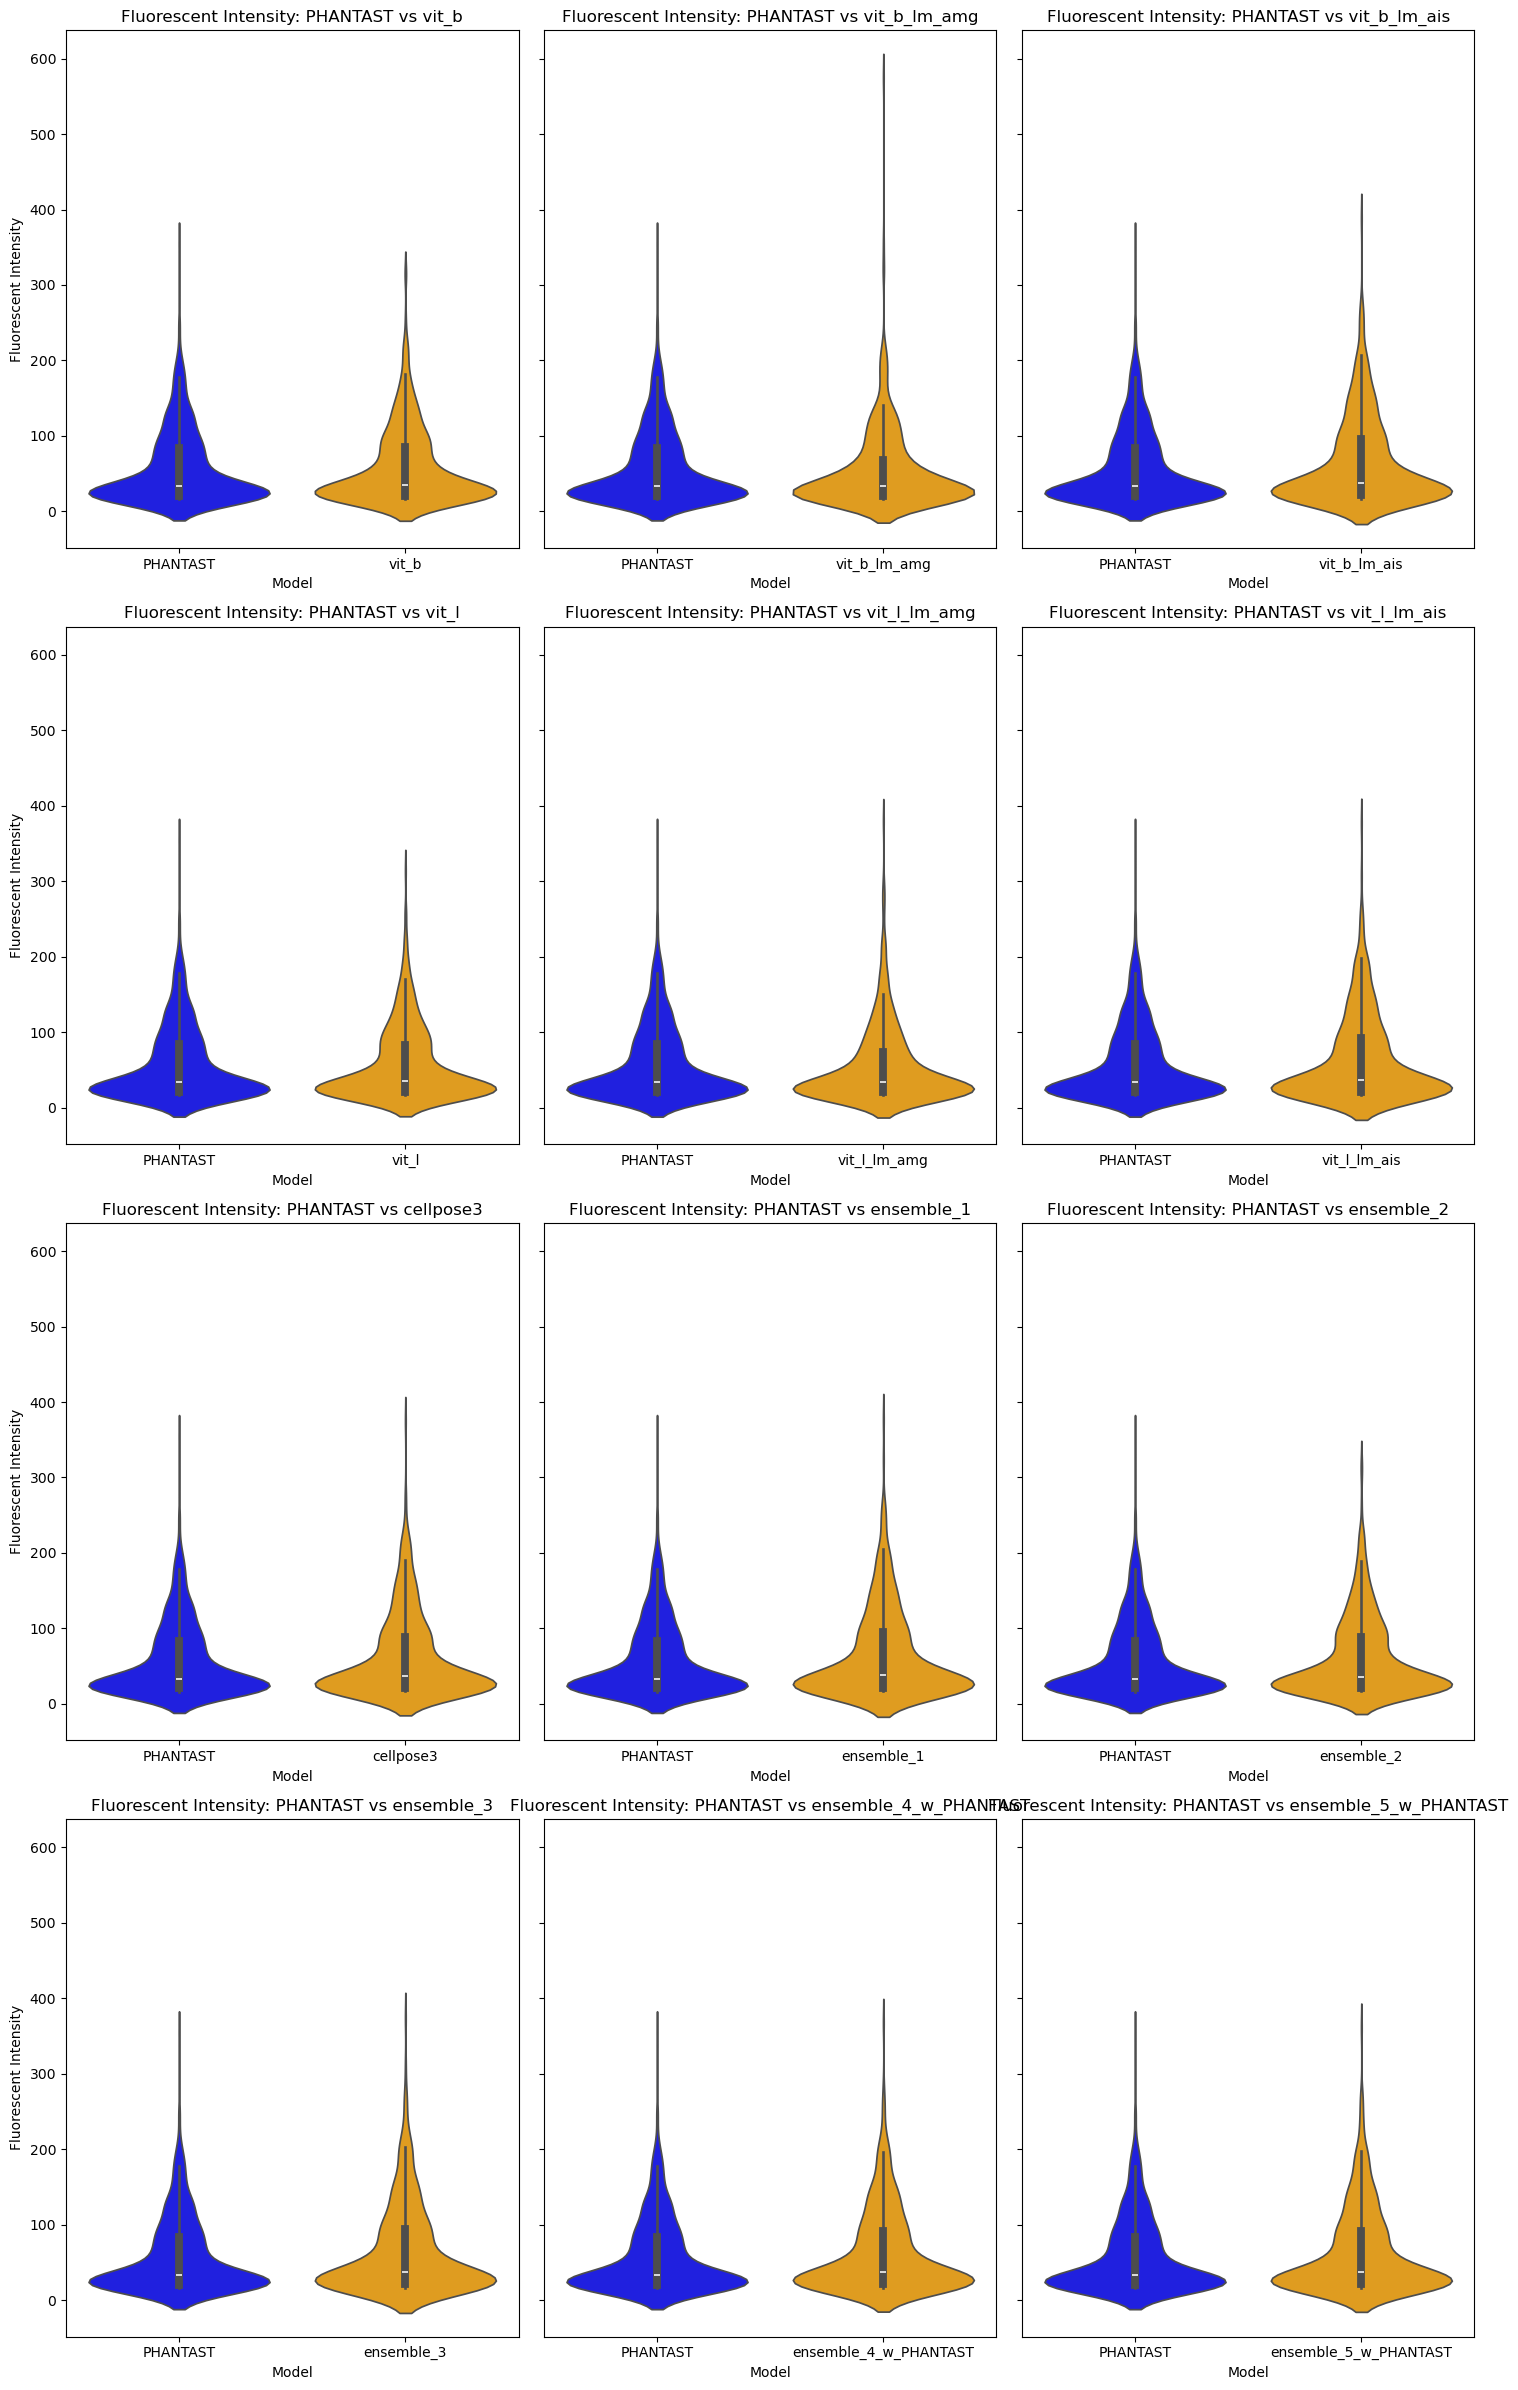

In [10]:
# Violin plots: PHANTAST vs other models for fluorescent intesity

plot_violin_plots_phantast('Mean', 'Fluorescent Intensity', using_gt=False, split=False)


Plotting for model: vit_b
Data for model (vit_b) head:
                                  Label    Area    Mean  Slice  MinThr  \
0  Result of Corrected_Flo_Image.tiff:1  254511  169.47      1       1   
1  Result of Corrected_Flo_Image.tiff:2  254511  124.58      2       1   
2  Result of Corrected_Flo_Image.tiff:3  482855  134.78      3       1   
3  Result of Corrected_Flo_Image.tiff:4  482855   57.82      4       1   
4  Result of Corrected_Flo_Image.tiff:5  555253  220.38      5       1   

   MaxThr Experiment  Model  
0   65535       exp1  vit_b  
1   65535       exp1  vit_b  
2   65535       exp1  vit_b  
3   65535       exp1  vit_b  
4   65535       exp1  vit_b  

Plotting for model: vit_b_lm_amg
Data for model (vit_b_lm_amg) head:
                                  Label   Area   Mean  Slice  MinThr  MaxThr  \
0  Result of Corrected_Flo_Image.tiff:1  94993  82.70      1       1   65535   
1  Result of Corrected_Flo_Image.tiff:2  94993  58.85      2       1   65535   
2  Result

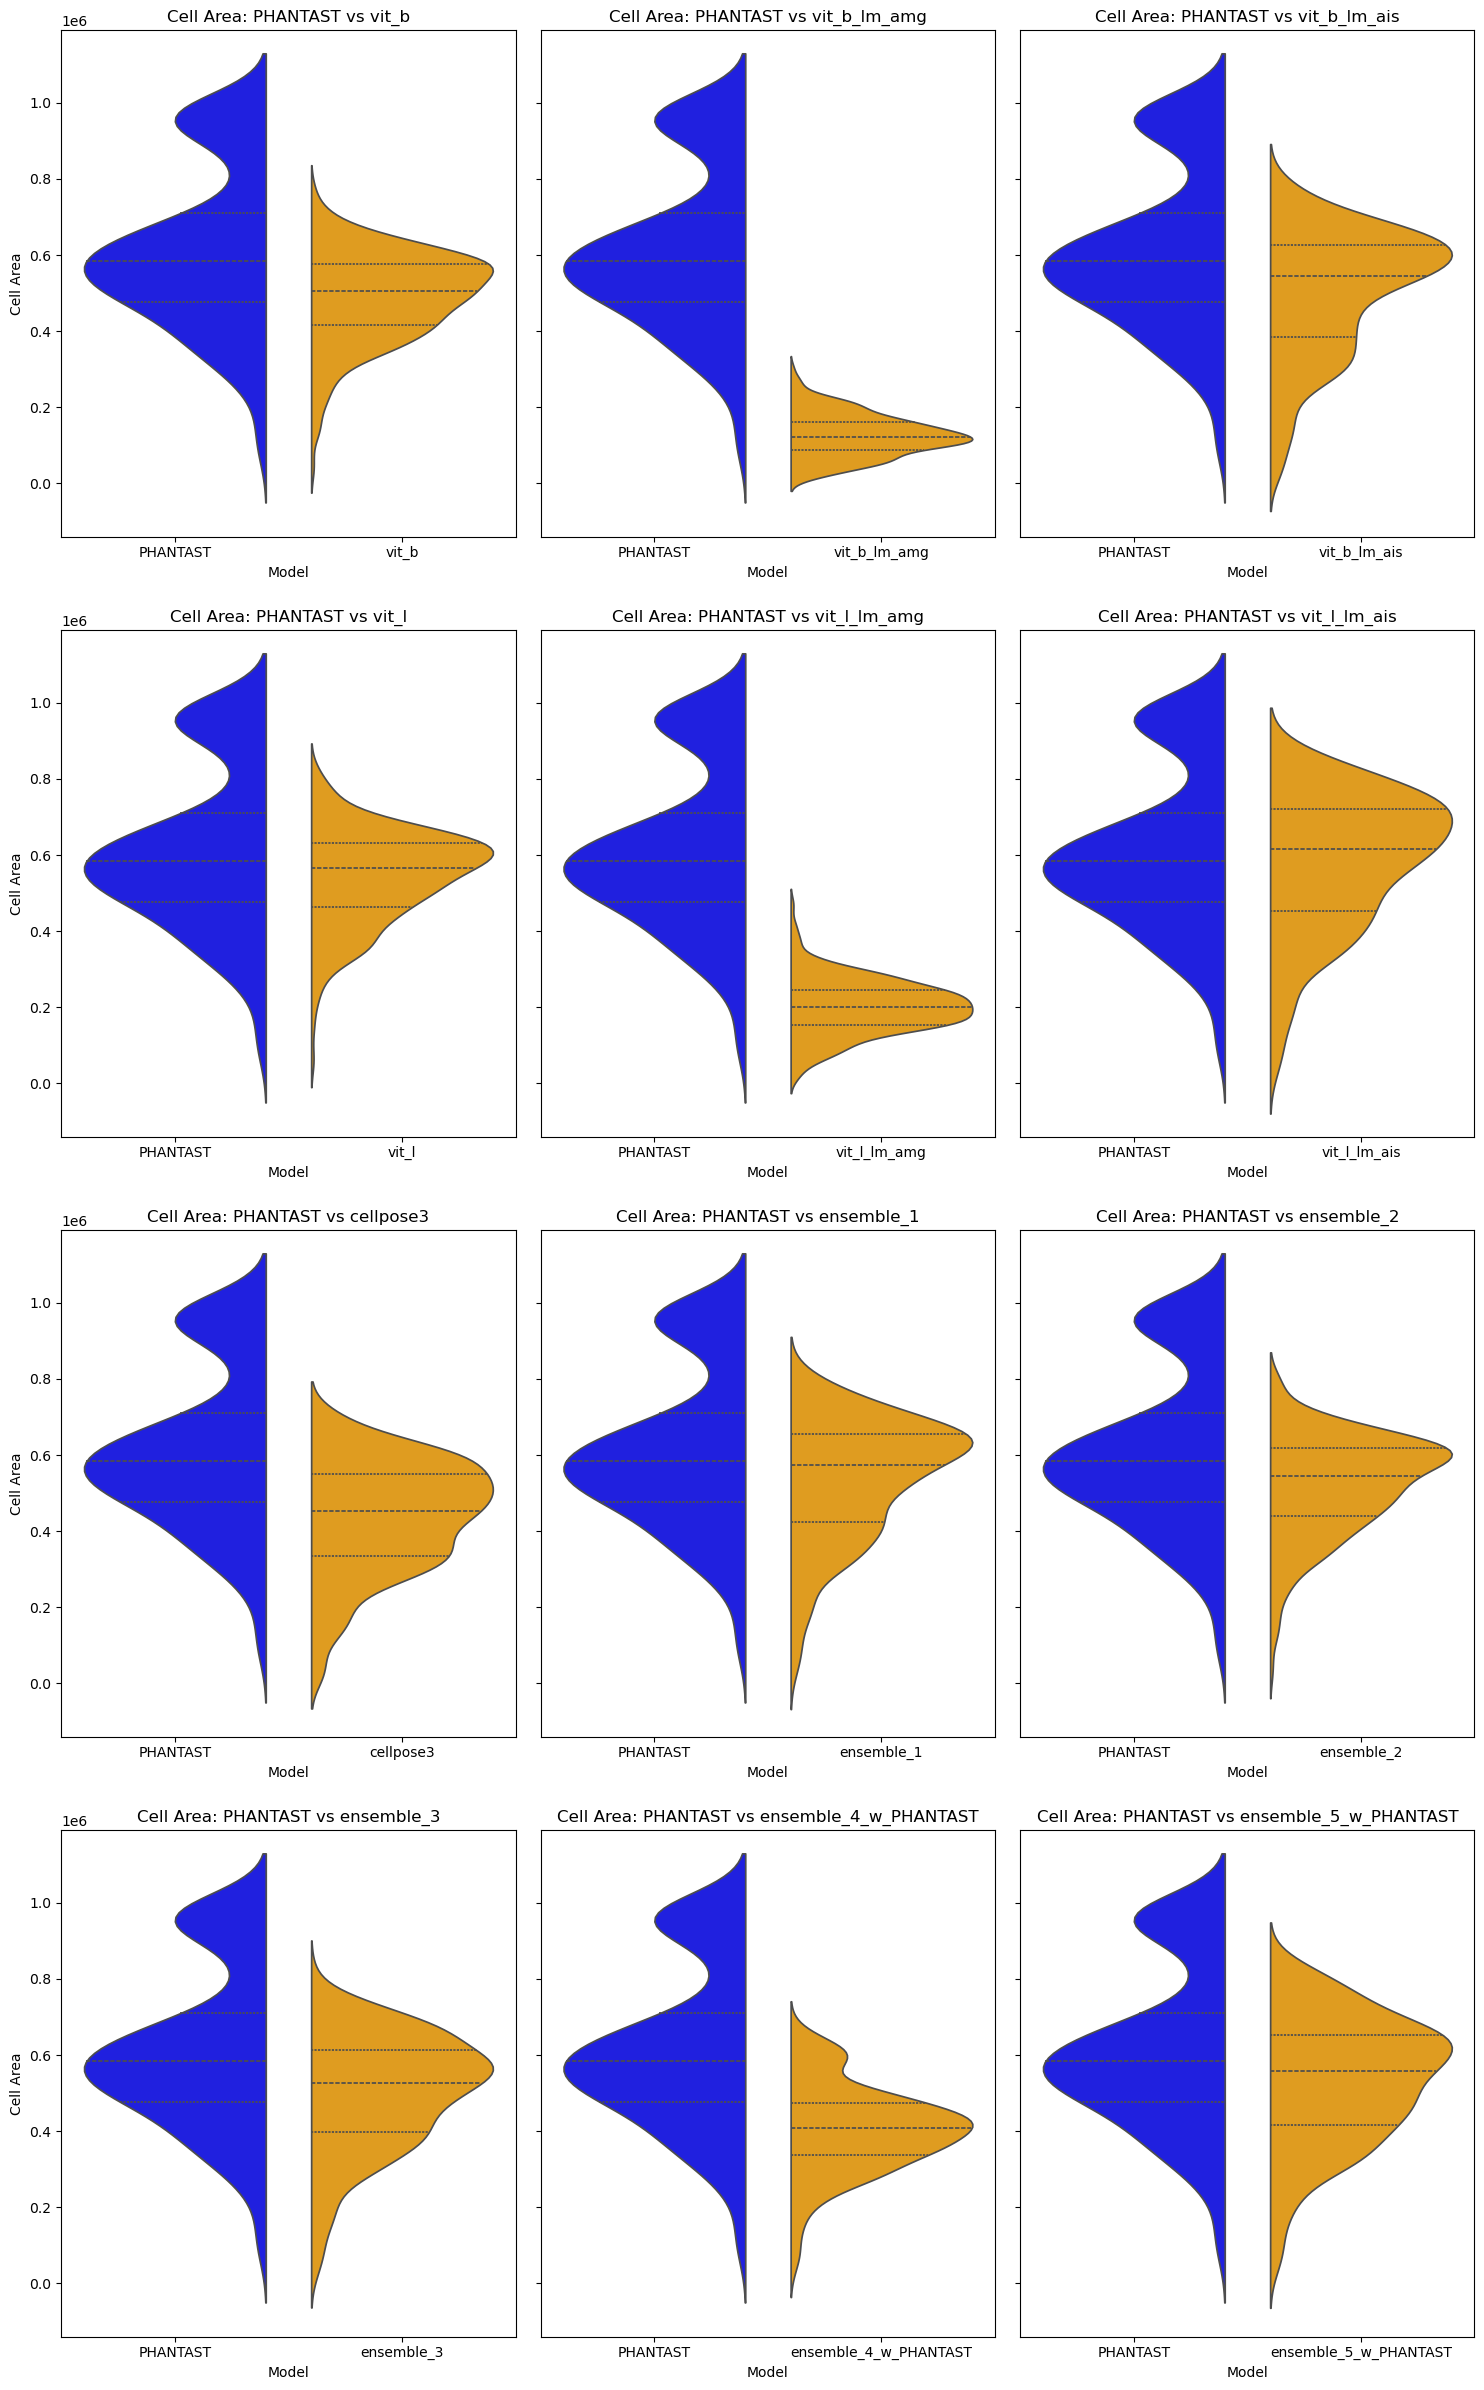

In [11]:
# Violin plots (split view): PHANTAST vs other models for cell area

plot_violin_plots_phantast('Area', 'Cell Area', using_gt=False, split=True)


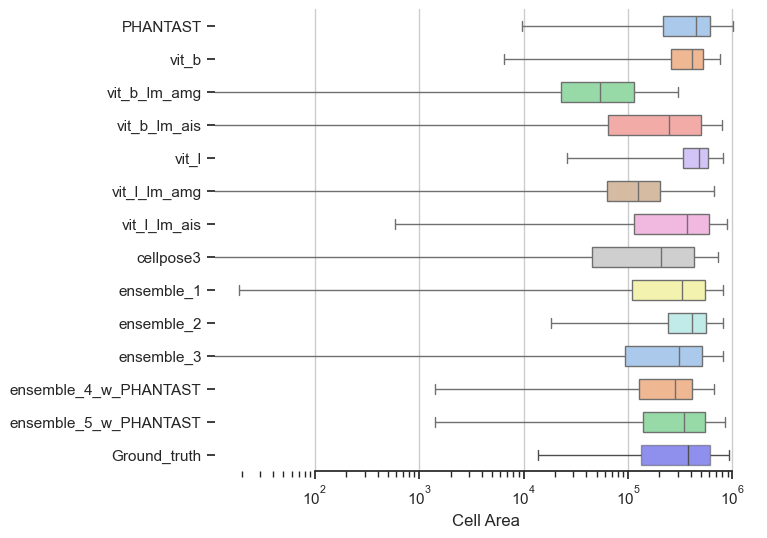

In [4]:
# Box plots (with optional strip plots): cell area

plot_box_plots(all_data, 'Area', 'Cell Area', ground_truth_df=ground_truth_df, stripplot=False)


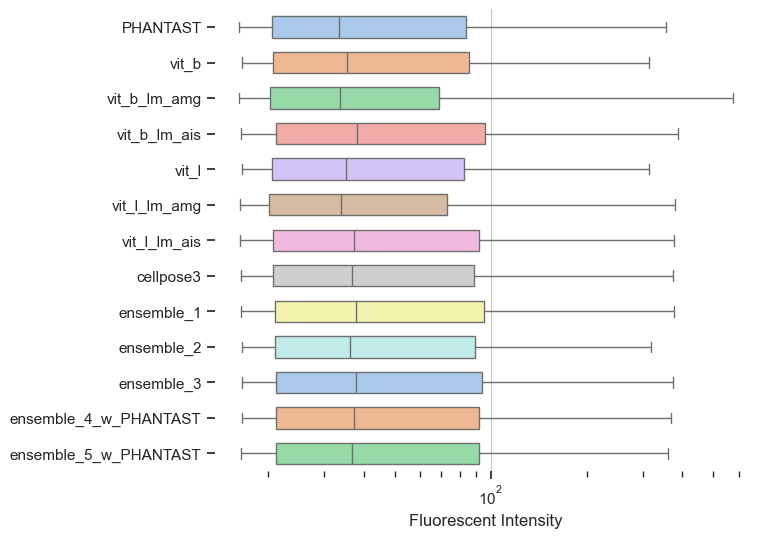

In [10]:
# Box plots (with optional strip plots): fluorescent intensity
plot_box_plots(all_model_data, 'Mean', 'Fluorescent Intensity', ground_truth_df=None, stripplot=False)

In [5]:
print(gt_data['PHANTAST'].head())
print(gt_data['Ground_truth'].head())


                           Label    Area  Mean  Slice  MinThr  MaxThr  \
0  Result of ground truth tiff:1  480956   NaN      1       1   65535   
1  Result of ground truth tiff:2  770701   NaN      2       1   65535   
2  Result of ground truth tiff:3  855305   NaN      3       1   65535   
3  Result of ground truth tiff:4  647943   NaN      4       1   65535   
4  Result of ground truth tiff:5  384132   NaN      5       1   65535   

      Model  
0  PHANTAST  
1  PHANTAST  
2  PHANTAST  
3  PHANTAST  
4  PHANTAST  
                           Label    Area  Mean  Slice  MinThr  MaxThr  \
0  Result of ground truth tiff:1  800257   NaN      1       1   65535   
1  Result of ground truth tiff:2  934640   NaN      2       1   65535   
2  Result of ground truth tiff:3  924582   NaN      3       1   65535   
3  Result of ground truth tiff:4  787529   NaN      4       1   65535   
4  Result of ground truth tiff:5  688895   NaN      5       1   65535   

          Model  
0  Ground_truth  
1 

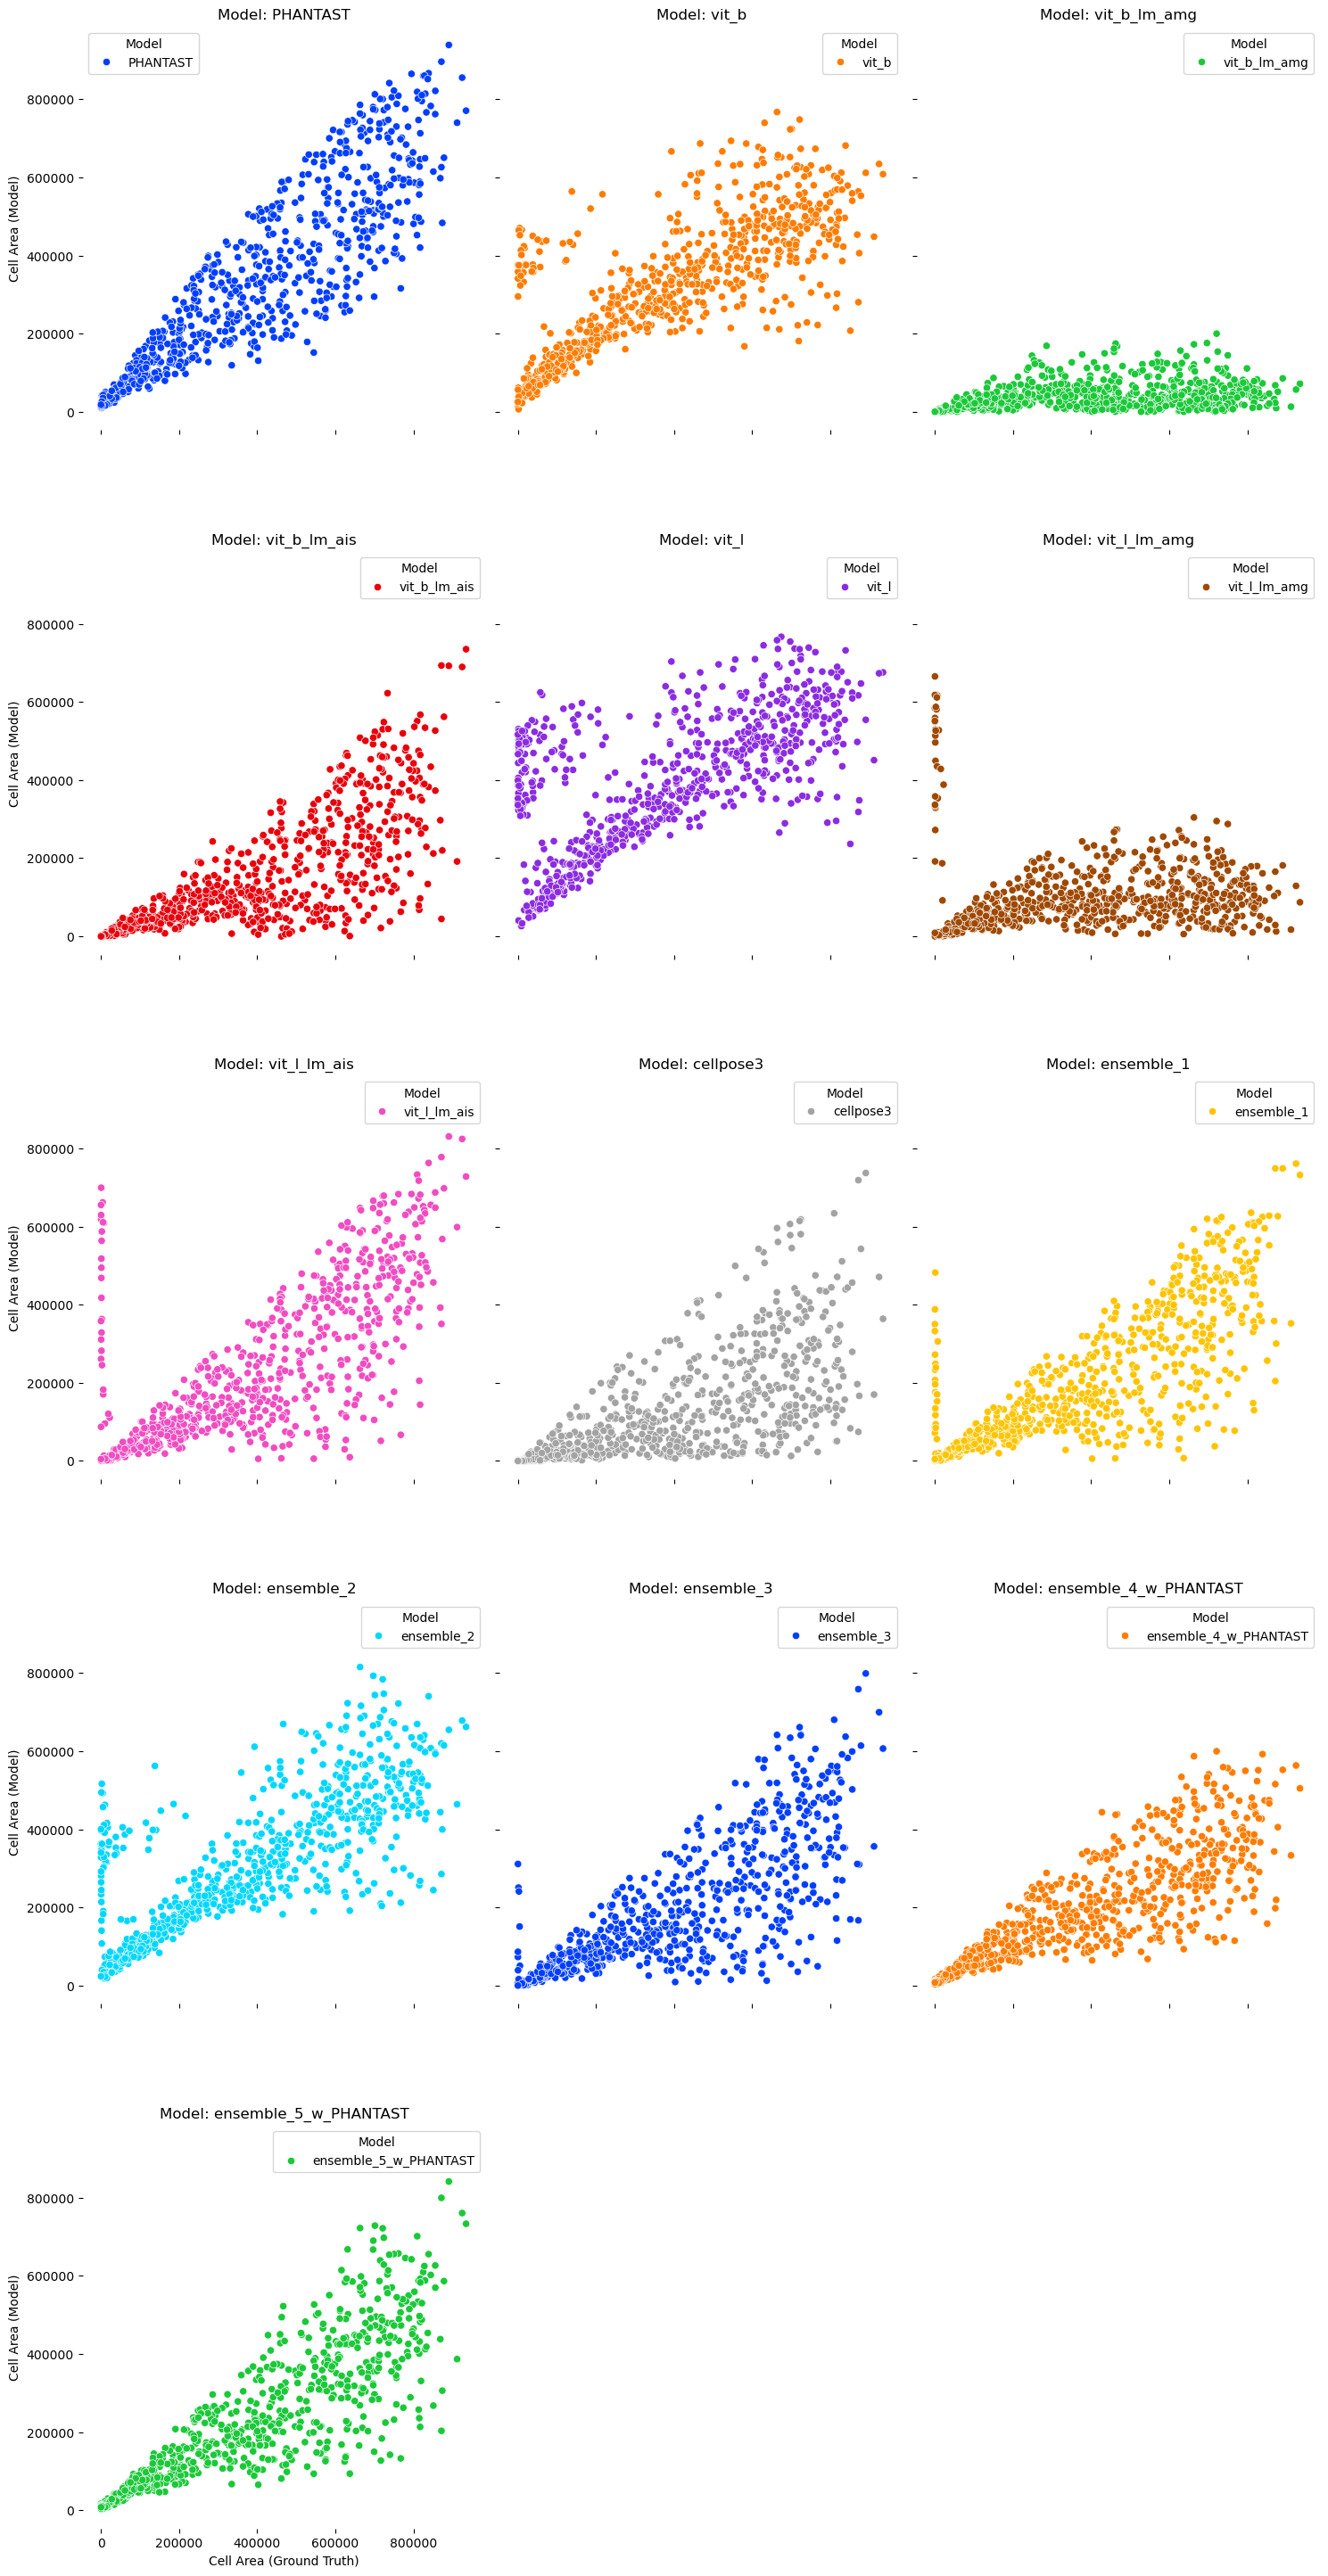

In [4]:
# Scatter plots: ground truth vs all models
plot_scatter_plots(gt_data, gt_data, models, data_to_plot='Area', y_axis_label='Cell Area')

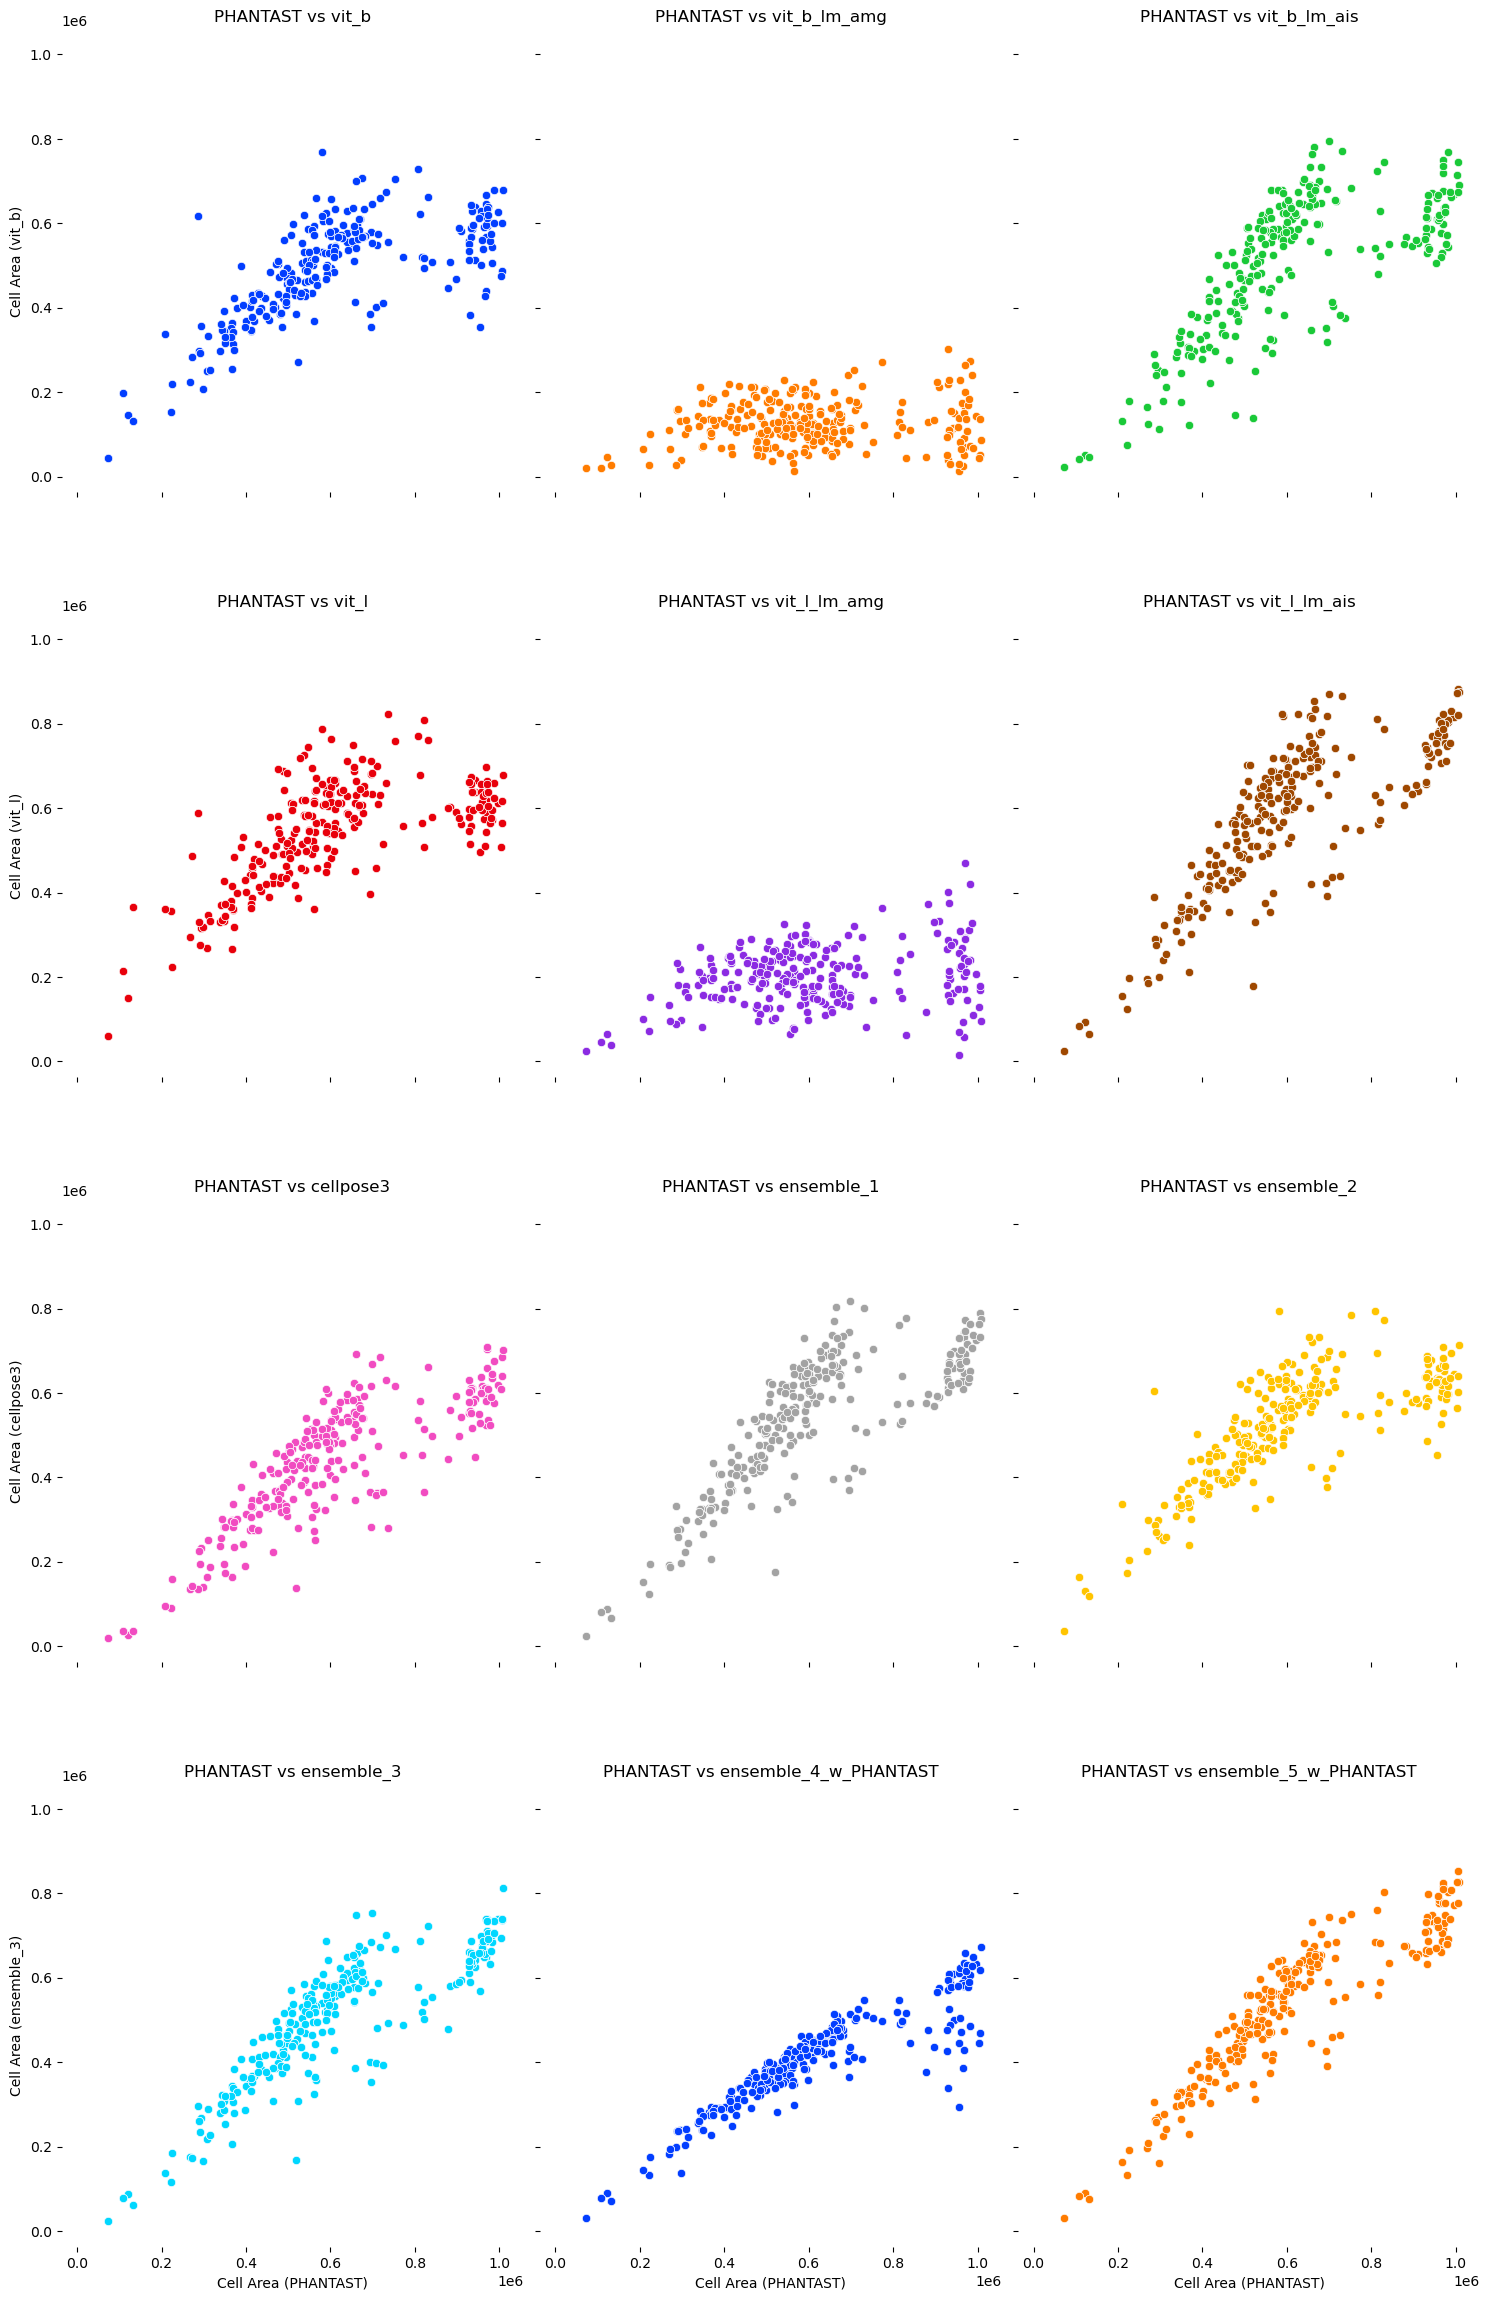

In [4]:
# Scatter plot: PHANTAST vs ML models for cell area
plot_scatter_phantast_vs_models(phantast_data, data_against_phantast, ml_models, data_to_plot='Area', y_axis_label='Cell Area')


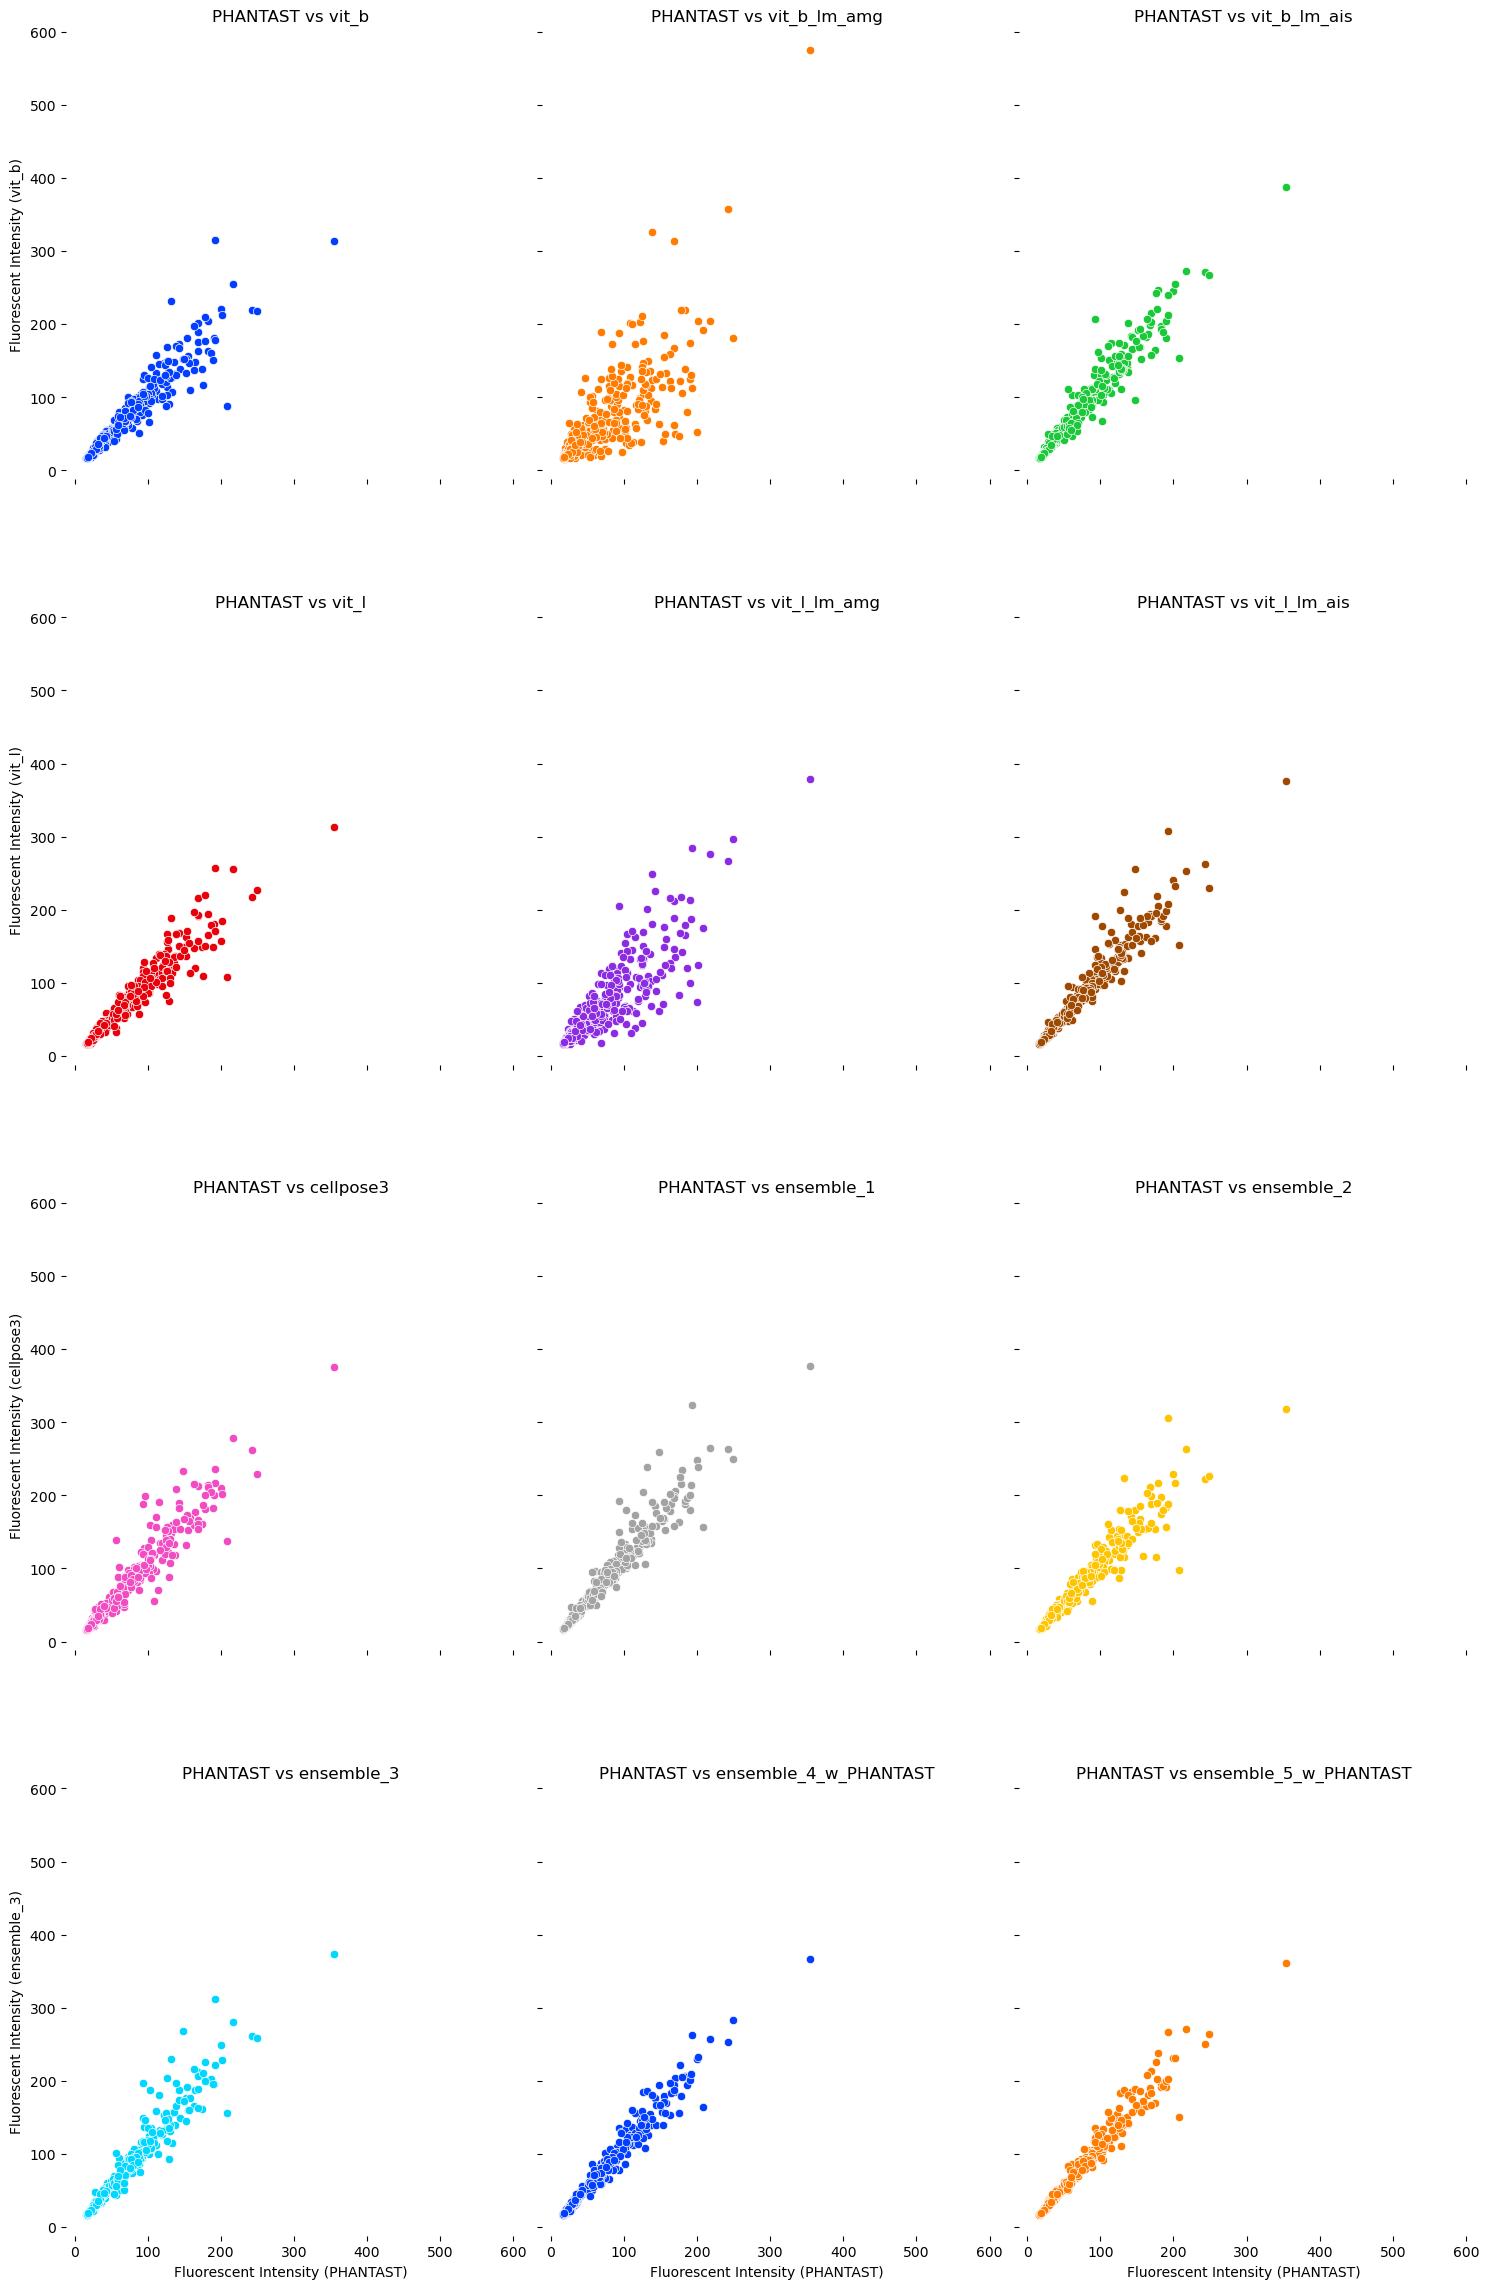

In [5]:
# Scatter plot: PHANTAST vs ML models for fluorescent intensity
plot_scatter_phantast_vs_models(phantast_data, data_against_phantast, ml_models, data_to_plot='Mean', y_axis_label='Fluorescent Intensity')

Part 2: MAE, etc for mean area and intensity FOR PHANTAST!!!!!

PHANTAST PHANTAST PHANTAST

Statistics for Each Model's Cell Area Predictions Compared to PHANTAST


,Model,MAE,MSE,RMSE,Correlation Coeff.
0,vit_b,0.129830,0.035422,0.188209,0.681067
1,vit_b_lm_amg,0.462199,0.254879,0.504856,0.104518
2,vit_b_lm_ais,0.125404,0.030566,0.174830,0.718750
3,vit_l,0.116320,0.028228,0.168010,0.641001
4,vit_l_lm_amg,0.390036,0.190094,0.435998,0.267215
5,vit_l_lm_ais,0.096609,0.015145,0.123067,0.805402
6,cellpose3,0.164422,0.040822,0.202045,0.820279
7,ensemble_1,0.101800,0.020660,0.143735,0.785618
8,ensemble_2,0.109129,0.025914,0.160979,0.748028
9,ensemble_3,0.109862,0.022815,0.151045,0.850871


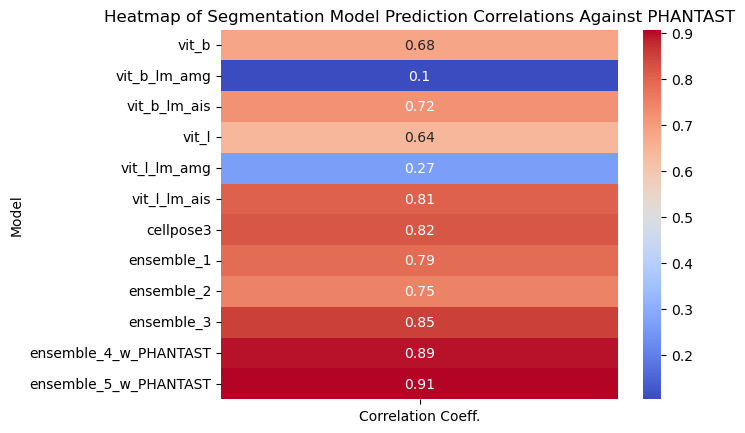

vit_b_lm_amg and PHANTAST: 0.1045
vit_l_lm_amg and PHANTAST: 0.2672
vit_l and PHANTAST: 0.6410
vit_b and PHANTAST: 0.6811
vit_b_lm_ais and PHANTAST: 0.7187
ensemble_2 and PHANTAST: 0.7480
ensemble_1 and PHANTAST: 0.7856
vit_l_lm_ais and PHANTAST: 0.8054
cellpose3 and PHANTAST: 0.8203
ensemble_3 and PHANTAST: 0.8509
ensemble_4_w_PHANTAST and PHANTAST: 0.8946
ensemble_5_w_PHANTAST and PHANTAST: 0.9064


In [5]:
# Stats for mean cell area
metrics = []

# Normalise area to be per pixel -- thus metrics will be error for misclassifying a pixel as cell or background
y_true = phantast_data['Area']/(1024**2)

for ml_model in ml_models:
    y_pred = nogt_data[ml_model]['Area']/(1024**2)

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    cc = y_true.corr(y_pred) # Pearson's r by default


    metrics.append({'Model': ml_model, 'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'Correlation Coeff.': cc})

metrics_df = pd.DataFrame(metrics)

print("Statistics for Each Model's Cell Area Predictions Compared to PHANTAST")
display(metrics_df)

# Create a DataFrame for the correlation coefficients
cc_df = metrics_df[['Model', 'Correlation Coeff.']].set_index('Model')

# Create a heatmap of the correlation coefficients
sns.heatmap(cc_df, annot=True, cmap='coolwarm')
plt.title('Heatmap of Segmentation Model Prediction Correlations Against PHANTAST')
plt.show()

# Print sorted list of correlation coefficients from lowest to highest
sorted_correlations = metrics_df[['Model', 'Correlation Coeff.']].sort_values(by='Correlation Coeff.')
for index, row in sorted_correlations.iterrows():
    print(f"{row['Model']} and PHANTAST: {row['Correlation Coeff.']:.4f}")

In [6]:

prinrr



gffffff

printhhhhhhhhhhhhhhhhhhhblsz;'dfj ainbdk .IUFFFFFFFDDrrvv# Stats for mean fluorescent intensity

metrics = []

# Normalise area to be per pixel -- thus metrics will be error for misclassifying a pixel as cell or background
y_true = phantast_data['Mean']/(1024**2)

for ml_model in ml_models:
    y_pred = nogt_data[ml_model]['Mean']/(1024**2)

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    cc = y_true.corr(y_pred) # Pearson's r by default


    metrics.append({'Model': ml_model, 'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'Correlation Coeff.': cc})

metrics_df = pd.DataFrame(metrics)

print("Statistics for Each Model's Fluorescent Intensity Measurements Compared to PHANTAST")
display(metrics_df)

Statistics for Each Model's Fluorescent Intensity Measurements Compared to PHANTAST


,Model,MAE,MSE,RMSE,Correlation Coeff.
0,vit_b,0.000006,1.775346e-10,0.000013,0.961215
1,vit_b_lm_amg,0.000016,9.387215e-10,0.000031,0.810832
2,vit_b_lm_ais,0.000009,2.447400e-10,0.000016,0.976016
3,vit_l,0.000006,1.409736e-10,0.000012,0.967417
4,vit_l_lm_amg,0.000012,4.948477e-10,0.000022,0.892699
5,vit_l_lm_ais,0.000007,2.169698e-10,0.000015,0.973481
6,cellpose3,0.000007,2.159879e-10,0.000015,0.966835
7,ensemble_1,0.000008,2.674237e-10,0.000016,0.973830
8,ensemble_2,0.000006,1.685852e-10,0.000013,0.967946
9,ensemble_3,0.000008,2.712493e-10,0.000016,0.972413


In [1]:
# Correlation Coefficient Stats Between Models, for ensembling (look for low correlations?) and analysis

correlation_dict = {}

for i, model in enumerate(nogt_data):
    correlation_dict[model] = nogt_data[model]['Area'] / (1024 ** 2)

# Create a DataFrame from the predictions dictionary
predictions = pd.DataFrame(correlation_dict)

# Calculate pairwise Pearson correlation
correlation_matrix = predictions.corr(method='pearson')
print("Pairwise Pearson Correlation Coefficients To Compare Model Correlation")
display(correlation_matrix)

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Heatmap of Segmentation Model Prediction Correlations')
plt.show()

# List lowest correlations
correlation_list = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        model_1 = correlation_matrix.columns[i]
        model_2 = correlation_matrix.columns[j]
        correlation_value = correlation_matrix.iloc[i, j]
        correlation_list.append((model_1, model_2, correlation_value))

# Sort the list of tuples by the correlation value
sorted_correlations = sorted(correlation_list, key=lambda x: x[2])

# Print from lowest to highest
for item in sorted_correlations:
    print(f"{item[0]} and {item[1]}: {item[2]:.4f}")

NameError: name 'nogt_data' is not defined

for ensemble, might try vit_b, vit_b_lm_amg, and PHANTAST. a low combination. vit_b_lm_amg consistently scores low, and vit_b and PHANTAST is vit_b's next lowest combo

PART 3: Dice/F1, Precision, and Recall/Sensitivity Compared to PHANTAST

Dilation Post-Processing of gt_exp3 - vit_l_lm_ais

In [7]:
# IoU with post-processing against ground truth
gt = tiff.imread(os.path.join(base_path, 'gt_exp3/Ground_truth/Segmentation_Output/GT_Mask_Stack.tiff'))

num_slices = gt.shape[0]

# Create an all-white image for comparison
iou_values = []
for i in range(num_slices):
    iou = calculate_iou(gt[i, :, :], np.ones_like(gt[i, :, :]))
    iou_values.append(iou)

average_iou = np.mean(iou_values)
print(f"Average IoU across slices for gt vs all white image: {average_iou}")


sample = tiff.imread(os.path.join(base_path, 'gt_exp3/Model_vit_l_lm_ais/Segmentation_Output/Mask_Stack.tiff'))

num_slices = sample.shape[0]

iou_values = []
for i in range(num_slices):
    iou = calculate_iou(gt[i, :, :], sample[i, :, :])
    iou_values.append(iou)

average_iou = np.mean(iou_values)
print(f"Average IoU across slices for gt_exp3 vit_l_lm_ais BEFORE dilating: {average_iou}")


num_slices = sample.shape[0]

ious_w_kernel = []
kernel_size = 25
for k in range(1, kernel_size):

    kernel = np.ones((k, k), np.uint8)

    dilated_slices = []
    iou_values = []

    # Dilate each slice
    for i in range(num_slices):
        slice_2d = sample[i, :, :]
        dilated_slice = cv2.dilate(slice_2d, kernel, iterations=1)
        dilated_slices.append(dilated_slice)

    # Convert back to 3D numpy array
    dilated_sample = np.stack(dilated_slices, axis=0)

    # Calculate IoU for each slice
    for i in range(num_slices):
        iou = calculate_iou(gt[i, :, :], dilated_sample[i, :, :])
        iou_values.append(iou)

    # Calculate average IoU across all slices
    average_iou = np.mean(iou_values)
    ious_w_kernel.append((f"{k}x{k}", average_iou)) 
    # print(f"Average IoU across slices for gt_exp3 vit_l_lm_ais AFTER dilating with kernel size {k}x{k}: {average_iou}")

print("Kernel Size vs. Average IoU, Sorted by IoU")
df_iou = pd.DataFrame(ious_w_kernel, columns=['Kernel Size', 'Average IoU'])
df_iou_sorted = df_iou.sort_values(by='Average IoU', ascending=False)
display(df_iou_sorted)

# # Save the dilated slices as a new TIFF stack
# output_path = os.path.join(base_path, 'TESTING/dilatedmask.tiff')
# tiff.imwrite(output_path, dilated_sample)


Average IoU across slices for gt vs all white image: 0.39599037170410156
Average IoU across slices for gt_exp3 vit_l_lm_ais BEFORE dilating: 0.4761465143370513
Kernel Size vs. Average IoU, Sorted by IoU


,Kernel Size,Average IoU
6,7x7,0.520092
7,8x8,0.519635
8,9x9,0.519066
5,6x6,0.517850
9,10x10,0.516865
4,5x5,0.515308
10,11x11,0.514709
11,12x12,0.511614
3,4x4,0.508755
12,13x13,0.508631


In [8]:
# # Display all IoU data (Display the DataFrame w/o modifications)

gt_iou_results_df = compute_iou_dataframe_gt(gt_masks_file_paths)
display(gt_iou_results_df)


,Experiment,Model,Mean_IoU,IoU_Scores
0,gt_exp1,PHANTAST,0.573925,"[0.4975279118043088, 0.7373410854529581, 0.796..."
1,gt_exp1,vit_b,0.430343,"[0.491451688528263, 0.5986809520355615, 0.6297..."
2,gt_exp1,vit_b_lm_amg,0.088016,"[0.054424706954448426, 0.07581017095561311, 0...."
3,gt_exp1,vit_b_lm_ais,0.384440,"[0.538848783724235, 0.7683545215391068, 0.7233..."
4,gt_exp1,vit_l,0.472906,"[0.5420262026115131, 0.6515391281606867, 0.660..."
5,gt_exp1,vit_l_lm_amg,0.173183,"[0.10815840581355174, 0.09231884228383415, 0.1..."
6,gt_exp1,vit_l_lm_ais,0.535045,"[0.5541327930876254, 0.7614826931898966, 0.865..."
7,gt_exp1,cellpose3,0.281896,"[0.21999692148801367, 0.38077667817545174, 0.4..."
8,gt_exp1,ensemble_1,0.488503,"[0.558538279529153, 0.7709114556491932, 0.8078..."
9,gt_exp1,ensemble_2,0.478759,"[0.5323665839460073, 0.6569815949392309, 0.693..."


In [9]:
phantast_iou_results_df = compute_iou_dataframe_phantast(phantast_masks_file_paths)
display(phantast_iou_results_df)

,Experiment,Model,Mean_IoU,IoU_Scores
0,exp1,PHANTAST,1.000000,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,exp1,vit_b,0.525453,"[0.5474054861900297, 0.5474054861900297, 0.523..."
2,exp1,vit_b_lm_amg,0.199809,"[0.25555468128922326, 0.25555468128922326, 0.1..."
3,exp1,vit_b_lm_ais,0.599153,"[0.3277427879798762, 0.3277427879798762, 0.569..."
4,exp1,vit_l,0.558019,"[0.5780209064087447, 0.5780209064087447, 0.542..."
5,exp1,vit_l_lm_amg,0.299773,"[0.4071906738353771, 0.4071906738353771, 0.211..."
6,exp1,vit_l_lm_ais,0.657809,"[0.5642817631106734, 0.5642817631106734, 0.584..."
7,exp1,cellpose3,0.537829,"[0.4456819372189521, 0.4456819372189521, 0.516..."
8,exp1,ensemble_1,0.637781,"[0.5473754934525624, 0.5473754934525624, 0.585..."
9,exp1,ensemble_2,0.582557,"[0.5752250421347224, 0.5752250421347224, 0.556..."


MAE, etc for mean area and intensity for PHANTAST
?

New title: Recall, Precision, and Dice Compared to GT or PHANTAST (specify in comparison variable)

In [11]:
# FOR gt or PHANTAST, just specify in comparison

comparison = 'PHANTAST' # PHANTAST or Ground_truth
if comparison == 'PHANTAST':
    file_dict = phantast_masks_file_paths
else: 
    file_dict = gt_masks_file_paths

recall_results = {} # Nested dictionaries - outer part
precision_results = {} 
dice_results = {}

# Calculate stats for each model per experiment
for exp, models in file_dict.items():
    compare_path = models[comparison]
    compare_mask = imread(compare_path)

    recall_results[exp] = {} # Nested dictionaries - inner part
    precision_results[exp] = {} 
    dice_results[exp] = {} 

    # Compare against each model for that experiment, skipping comparison
    for model, path in models.items():
        if model == comparison:
            continue 
        model_mask = imread(path)
        recall = recall_score_(compare_mask, model_mask)
        recall_results[exp][model] = recall
        precision = precision_score_(compare_mask, model_mask)
        precision_results[exp][model] = precision
        dice = dice_coef(compare_mask, model_mask)
        dice_results[exp][model] = dice

# Display results
recall_df = pd.DataFrame.from_dict(recall_results, orient='columns')
print(f"Recall of Non-finetuned Models Compared to {comparison}")
display(recall_df)

summary_results_recall = recall_df.mean(axis=1).reset_index()
summary_results_recall.columns = ['Model', 'Mean Recall']
# print(f"Mean Recall of Non-finetuned Models Compared to {comparison} (Sorted)")
# display(summary_results_recall.sort_values(by='Mean Recall', ascending=False))

precision_df = pd.DataFrame.from_dict(precision_results, orient='columns')
print(f"Precision of Non-finetuned Models Compared to {comparison}")
display(precision_df)

summary_results_precision = precision_df.mean(axis=1).reset_index()
summary_results_precision.columns = ['Model', 'Mean Precision']
# print(f"Mean Precision of Non-finetuned Models Compared to {comparison} (Sorted)")
# display(summary_results_precision.sort_values(by='Mean Precision', ascending=False))

dice_df = pd.DataFrame.from_dict(dice_results, orient='columns')
print(f"Dice Coefficient of Non-finetuned Models Compared to {comparison}")
display(dice_df)

summary_results_dice = dice_df.mean(axis=1).reset_index()
summary_results_dice.columns = ['Model', 'Mean Dice Coefficient']
# print(f"Mean Dice Coefficient of Non-finetuned Models Compared to {comparison} (Sorted)")
# display(summary_results_dice.sort_values(by='Mean Dice Coefficient', ascending=False))

# Display all 3 metrics
summary_results = pd.merge(summary_results_recall, summary_results_precision, on='Model')
summary_results = pd.merge(summary_results, summary_results_dice, on='Model')

print(f"Mean Recall, Precision, and Dice Coefficients of Non-finetuned Models Compared to {comparison} (Sorted by Dice)")
display(summary_results.sort_values(by='Mean Dice Coefficient', ascending=False))


Recall of Non-finetuned Models Compared to PHANTAST


,exp1,exp2,exp3,exp4,exp5
vit_b,0.615939,0.632564,0.636832,0.608668,0.615707
vit_b_lm_amg,0.190032,0.209101,0.180015,0.165508,0.184571
vit_b_lm_ais,0.692251,0.695579,0.707461,0.689682,0.660006
vit_l,0.673876,0.672861,0.677824,0.659988,0.656885
vit_l_lm_amg,0.300811,0.305545,0.284365,0.266644,0.279003
vit_l_lm_ais,0.777909,0.776136,0.794163,0.789496,0.765588
cellpose3,0.608927,0.617481,0.629573,0.606064,0.590801
ensemble_1,0.736386,0.735243,0.749461,0.735806,0.711733
ensemble_2,0.678295,0.680363,0.691728,0.669744,0.662246
ensemble_3,0.695892,0.697581,0.713317,0.695841,0.680122


Precision of Non-finetuned Models Compared to PHANTAST


,exp1,exp2,exp3,exp4,exp5
vit_b,0.782180,0.771307,0.771288,0.754086,0.787252
vit_b_lm_amg,0.911711,0.873856,0.903967,0.888635,0.907844
vit_b_lm_ais,0.848134,0.823684,0.836327,0.834125,0.847004
vit_l,0.767387,0.744798,0.755680,0.725053,0.762520
vit_l_lm_amg,0.885430,0.847286,0.868061,0.860973,0.878276
vit_l_lm_ais,0.835976,0.805080,0.817109,0.815110,0.827085
cellpose3,0.858001,0.825562,0.859095,0.838769,0.864429
ensemble_1,0.847950,0.822533,0.833874,0.831149,0.842784
ensemble_2,0.811724,0.790590,0.785196,0.772973,0.805732
ensemble_3,0.858507,0.833938,0.851173,0.838948,0.858285


Dice Coefficient of Non-finetuned Models Compared to PHANTAST


,exp1,exp2,exp3,exp4,exp5
vit_b,0.689176,0.695080,0.697641,0.673618,0.690992
vit_b_lm_amg,0.314509,0.337454,0.300240,0.279044,0.306773
vit_b_lm_ais,0.762305,0.754231,0.766515,0.755058,0.741903
vit_l,0.717598,0.707005,0.714638,0.690992,0.705772
vit_l_lm_amg,0.449061,0.449127,0.428394,0.407183,0.423479
vit_l_lm_ais,0.805898,0.790343,0.805473,0.802099,0.795149
cellpose3,0.712318,0.706519,0.726640,0.703676,0.701890
ensemble_1,0.788240,0.776442,0.789417,0.780577,0.771734
ensemble_2,0.739035,0.731347,0.735505,0.717665,0.726977
ensemble_3,0.768693,0.759689,0.776172,0.760723,0.758887


Mean Recall, Precision, and Dice Coefficients of Non-finetuned Models Compared to PHANTAST (Sorted by Dice)


,Model,Mean Recall,Mean Precision,Mean Dice Coefficient
11,ensemble_5_w_PHANTAST,0.790560,0.908448,0.845352
5,vit_l_lm_ais,0.780658,0.820072,0.799792
7,ensemble_1,0.733726,0.835658,0.781282
10,ensemble_4_w_PHANTAST,0.647943,0.976836,0.779026
9,ensemble_3,0.696551,0.848170,0.764833
2,vit_b_lm_ais,0.688996,0.837855,0.756002
8,ensemble_2,0.676475,0.793243,0.730106
6,cellpose3,0.610569,0.849171,0.710209
3,vit_l,0.668287,0.751088,0.707201
0,vit_b,0.621942,0.773223,0.689301


New Title: Mean Cell Area for Comparison Against PHANTAST

In [ ]:
# Stats for mean cell area
metrics = []

# Normalise area to be per pixel -- thus metrics will be error for misclassifying a pixel as cell or background
y_true = phantast_data['Area']/(1024**2)

for model in models:
    y_pred = nogt_data[model]['Area']/(1024**2)

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    cc = y_true.corr(y_pred) # Pearson's r by default

    metrics.append({'Model': model, 'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'Correlation Coeff.': cc})

metrics_df = pd.DataFrame(metrics)

print("Statistics for Each Model's Cell Area Predictions Compared to PHANTAST")
display(metrics_df)

# Create a DataFrame for the correlation coefficients
cc_df = metrics_df[['Model', 'Correlation Coeff.']].set_index('Model')

# Create a heatmap of the correlation coefficients
sns.heatmap(cc_df, annot=True, cmap='coolwarm')
plt.title('Heatmap of Segmentation Model Prediction Correlations Against PHANTAST')
plt.show()

# Print sorted list of correlation coefficients from lowest to highest
sorted_correlations = metrics_df[['Model', 'Correlation Coeff.']].sort_values(by='Correlation Coeff.')
for index, row in sorted_correlations.iterrows():
    print(f"{row['Model']} and PHANTAST: {row['Correlation Coeff.']:.4f}")